##

### Setup

In [ ]:
import os
import gc
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from zillow.features.break_down import break_down_censuses
from zillow.config.feature_engineering import FeaturesDtypeConversionConfig_v1
from zillow.dataclasses.semantic_features_manager import SemanticFeaturesManager
from zillow.utils.common import read_data, find_shared_cols, read_data, is_bool_false
from zillow.config.config import load_config_no_wrap, create_config_from_dict, merge_configs
from zillow.config.paths import PROCESSED_DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, REPORTS_DIR, ANALYSIS_RESULTS_DIR

cfg = load_config_no_wrap('default')
cur_cfg = create_config_from_dict({
    'load_all_data': True,
    'main_train_path': INTERIM_DATA_DIR / 'cleaned_train_2016_v1.0.parquet',
})
cfg = merge_configs(cfg, cur_cfg)

np.random.seed(cfg.RSEED)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

sample_submission = pd.read_csv(RAW_DATA_DIR / "sample_submission.csv")
zillow_dictionary = pd.read_csv(RAW_DATA_DIR / "zillow_data_dictionary.csv")

if cfg.to_load_all_data:
    properties_2016 = read_data(path=INTERIM_DATA_DIR / "cleaned_properties_2016_v1.0.parquet", dtype='default')
    properties_2017 = read_data(path=INTERIM_DATA_DIR / "cleaned_properties_2017_v1.0.parquet", dtype='default')
    train_2016 = read_data(path=INTERIM_DATA_DIR / "cleaned_train_2016_v1.0.parquet", dtype='default')
    train_2017 = read_data(path=INTERIM_DATA_DIR / "cleaned_train_2017_v1.0.parquet", dtype='default')

train = read_data(cfg.main_train_path, dtype='default')

features_dtype_cfg = FeaturesDtypeConversionConfig_v1()


In [2]:
WORKING_PATH = "../../"
DATA_DIR = WORKING_PATH + "data/"

class Config:
    RSEED = 42
    target = 'logerror'

np.random.seed(Config.RSEED)

In [3]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Load data

In [4]:
name = 'cleaned_train_2016_v1.0.parquet'
train = read_data(f"{DATA_DIR}{name}", dtype=None)
zillow_dictionary = pd.read_csv(f"{DATA_DIR}zillow_data_dictionary.csv")

### Utils

In [5]:
def plot_heatmap(corr, title="", annot=True, figsize=(12, 10), *args, **kwargs):
    plt.figure(figsize=figsize)

    # Create a mask for the upper triangle to avoid redundancy
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, 
                annot=annot, fmt=".2f", cbar_kws={"shrink": .8}, **kwargs)

    plt.title(title, fontsize=16)
    plt.tight_layout()

In [6]:
# TODO: how to read big feature spaces? Just one by one no shortcut?
# TODO: is milestone idea writing -> obsidian later workflow good?

features_manager = SemanticFeaturesManager()

In [7]:
# TODO fix kwargs
# TODO: What is the best way to broaden the output of pandas description with mine new generated criterions?
def generate_full_num_df_summary(data, **kwargs):
    kwargs = kwargs.get('kwargs', {})

    num_data = data.select_dtypes([np.number])
    num_data = generate_advanced_num_metrics(num_data, kwargs.get('dtype_to_convert', None))

    desc = data.describe().T
    full_summary = desc.join(num_data)

    return full_summary.T

def generate_advanced_num_metrics(data, dtype_to_convert=None):
    if data.empty:
        return pd.DataFrame()

    extra = pd.DataFrame({
        'skewness':    data.skew(),
        'kurtosis':    data.kurtosis(),
        'miss_frac': np.round(data.isnull().mean(), decimals=4),
        'n_unique':    data.nunique(), 
        'dtype': data.dtypes
    })

    if dtype_to_convert is not None: 
        convertible = check_columns_convertable(data, dtype_to_convert)
        extra[f'is_{dtype_to_convert.__name__}_suit'] = [convertible[c] for c in data]

    return extra

# TODO: How to check which columns of a DataFrame can be converted to another type?
def check_columns_convertable(data, dtype):
    convertible = {}
    for c in data.columns:
        feature = data[c]
        non_null_feature = feature.dropna()
        convertible[c] = (non_null_feature.astype(dtype) == non_null_feature).all()
    return convertible

In [8]:
def do_basic_visuals(data, **kwargs):
    print(f"There are {len(data.columns)} features. ")
    display("Description of the features from zillow:", 
          zillow_dictionary[zillow_dictionary['feature'].isin(data.columns)])
    print("Unique dtypes:", data[data.columns].dtypes.unique()) 

    full_summary = generate_full_num_df_summary(data, kwargs=kwargs.get('num_args', {}))
    # TODO: How to print df beautifully like jupyter kernel does (as a structured table)? Can I use this function everywhere?
    if full_summary is not None:
        print("\nInspection per feature:")
        display(full_summary)

    do_basic_histplots(data, kwargs.get('plot_kws', {}))

def do_basic_histplots(data, plot_kws={}):
    print("Histplot visuals:")
    nfeats = data.columns.shape[0]
    ncols = min(plot_kws.get('ncols', 2), nfeats)
    nrows = nfeats // ncols + nfeats % ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(26, 18))
    to_annotate_counts = plot_kws.get('to_annotate_counts', False)

    # One more dimension to handle plots with only <= 2 axes. 
    axes = np.atleast_2d(axes).reshape(nrows, ncols)

    for i, feat_name in enumerate(data.columns):
        vector = data[feat_name]
        rowi, coli = divmod(i, ncols)
        ax = axes[rowi, coli]

        if isinstance(vector.dtype, pd.CategoricalDtype):
            max_bars = plot_kws.get('max_bars', 20)
            sns.countplot(x=vector, ax=ax, 
                          order=vector.value_counts().iloc[:max_bars].index)
            ax.tick_params(axis='x', labelsize=15)
        else:
            sns.histplot(vector, bins=min(
                                        plot_kws.get('bins', 20), 
                                        vector.nunique()
                                        ), ax=ax)

        if vector.nunique() < 10 or to_annotate_counts:
            annotate_bin_counts(ax)
            # TODO: How to remove axis on an ax? Only numbers on the axis, not lines?
            ax.set_yticklabels([])

    plt.tight_layout()
    plt.show()

def annotate_bin_counts(ax):
    # TODO sudy how it's done in detail.
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Only annotate bars with data
            x = p.get_x() + p.get_width()/2.
            y = height + 5 # + small gap
            ax.annotate(f'{int(height)}',
                    (x, y),
                    ha='center', va='bottom', fontsize=15)

### Features

##### Rooms

There are 6 features. 


'Description of the features from zillow:'

,feature,description
3,bathroomcnt,Number of bathrooms in home including fractional bathrooms
4,bedroomcnt,Number of bedrooms in home
7,calculatedbathnbr,Number of bathrooms in home including fractional bathroom
9,threequarterbathnbr,Number of 3/4 bathrooms in house (shower + sink + toilet)
20,fullbathcnt,"Number of full bathrooms (sink, shower + bathtub, and toilet) present in home"
44,roomcnt,Total number of rooms in the principal residence


Unique dtypes: [dtype('float64') dtype('int8') dtype('float32') Int8Dtype()]

Inspection per feature:


,threequarterbathnbr,roomcnt,bedroomcnt,calculatedbathnbr,bathroomcnt,fullbathcnt
count,11983.0,90026.0,90026.0,88856.0,90026.0,88856.0
mean,1.008762,1.478628,3.032002,2.309129,2.279614,2.241109
std,0.100939,2.819966,1.155785,0.976096,1.003989,0.963065
min,1.0,0.0,0.0,1.0,0.0,1.0
25%,1.0,0.0,2.0,2.0,2.0,2.0
50%,1.0,0.0,3.0,2.0,2.0,2.0
75%,1.0,0.0,4.0,3.0,3.0,3.0
max,4.0,18.0,16.0,20.0,20.0,20.0
skewness,13.131157,1.542545,0.76354,1.499315,1.292543,1.563744
kurtosis,207.160715,0.772725,4.405802,6.632369,5.99968,6.958886


Histplot visuals:


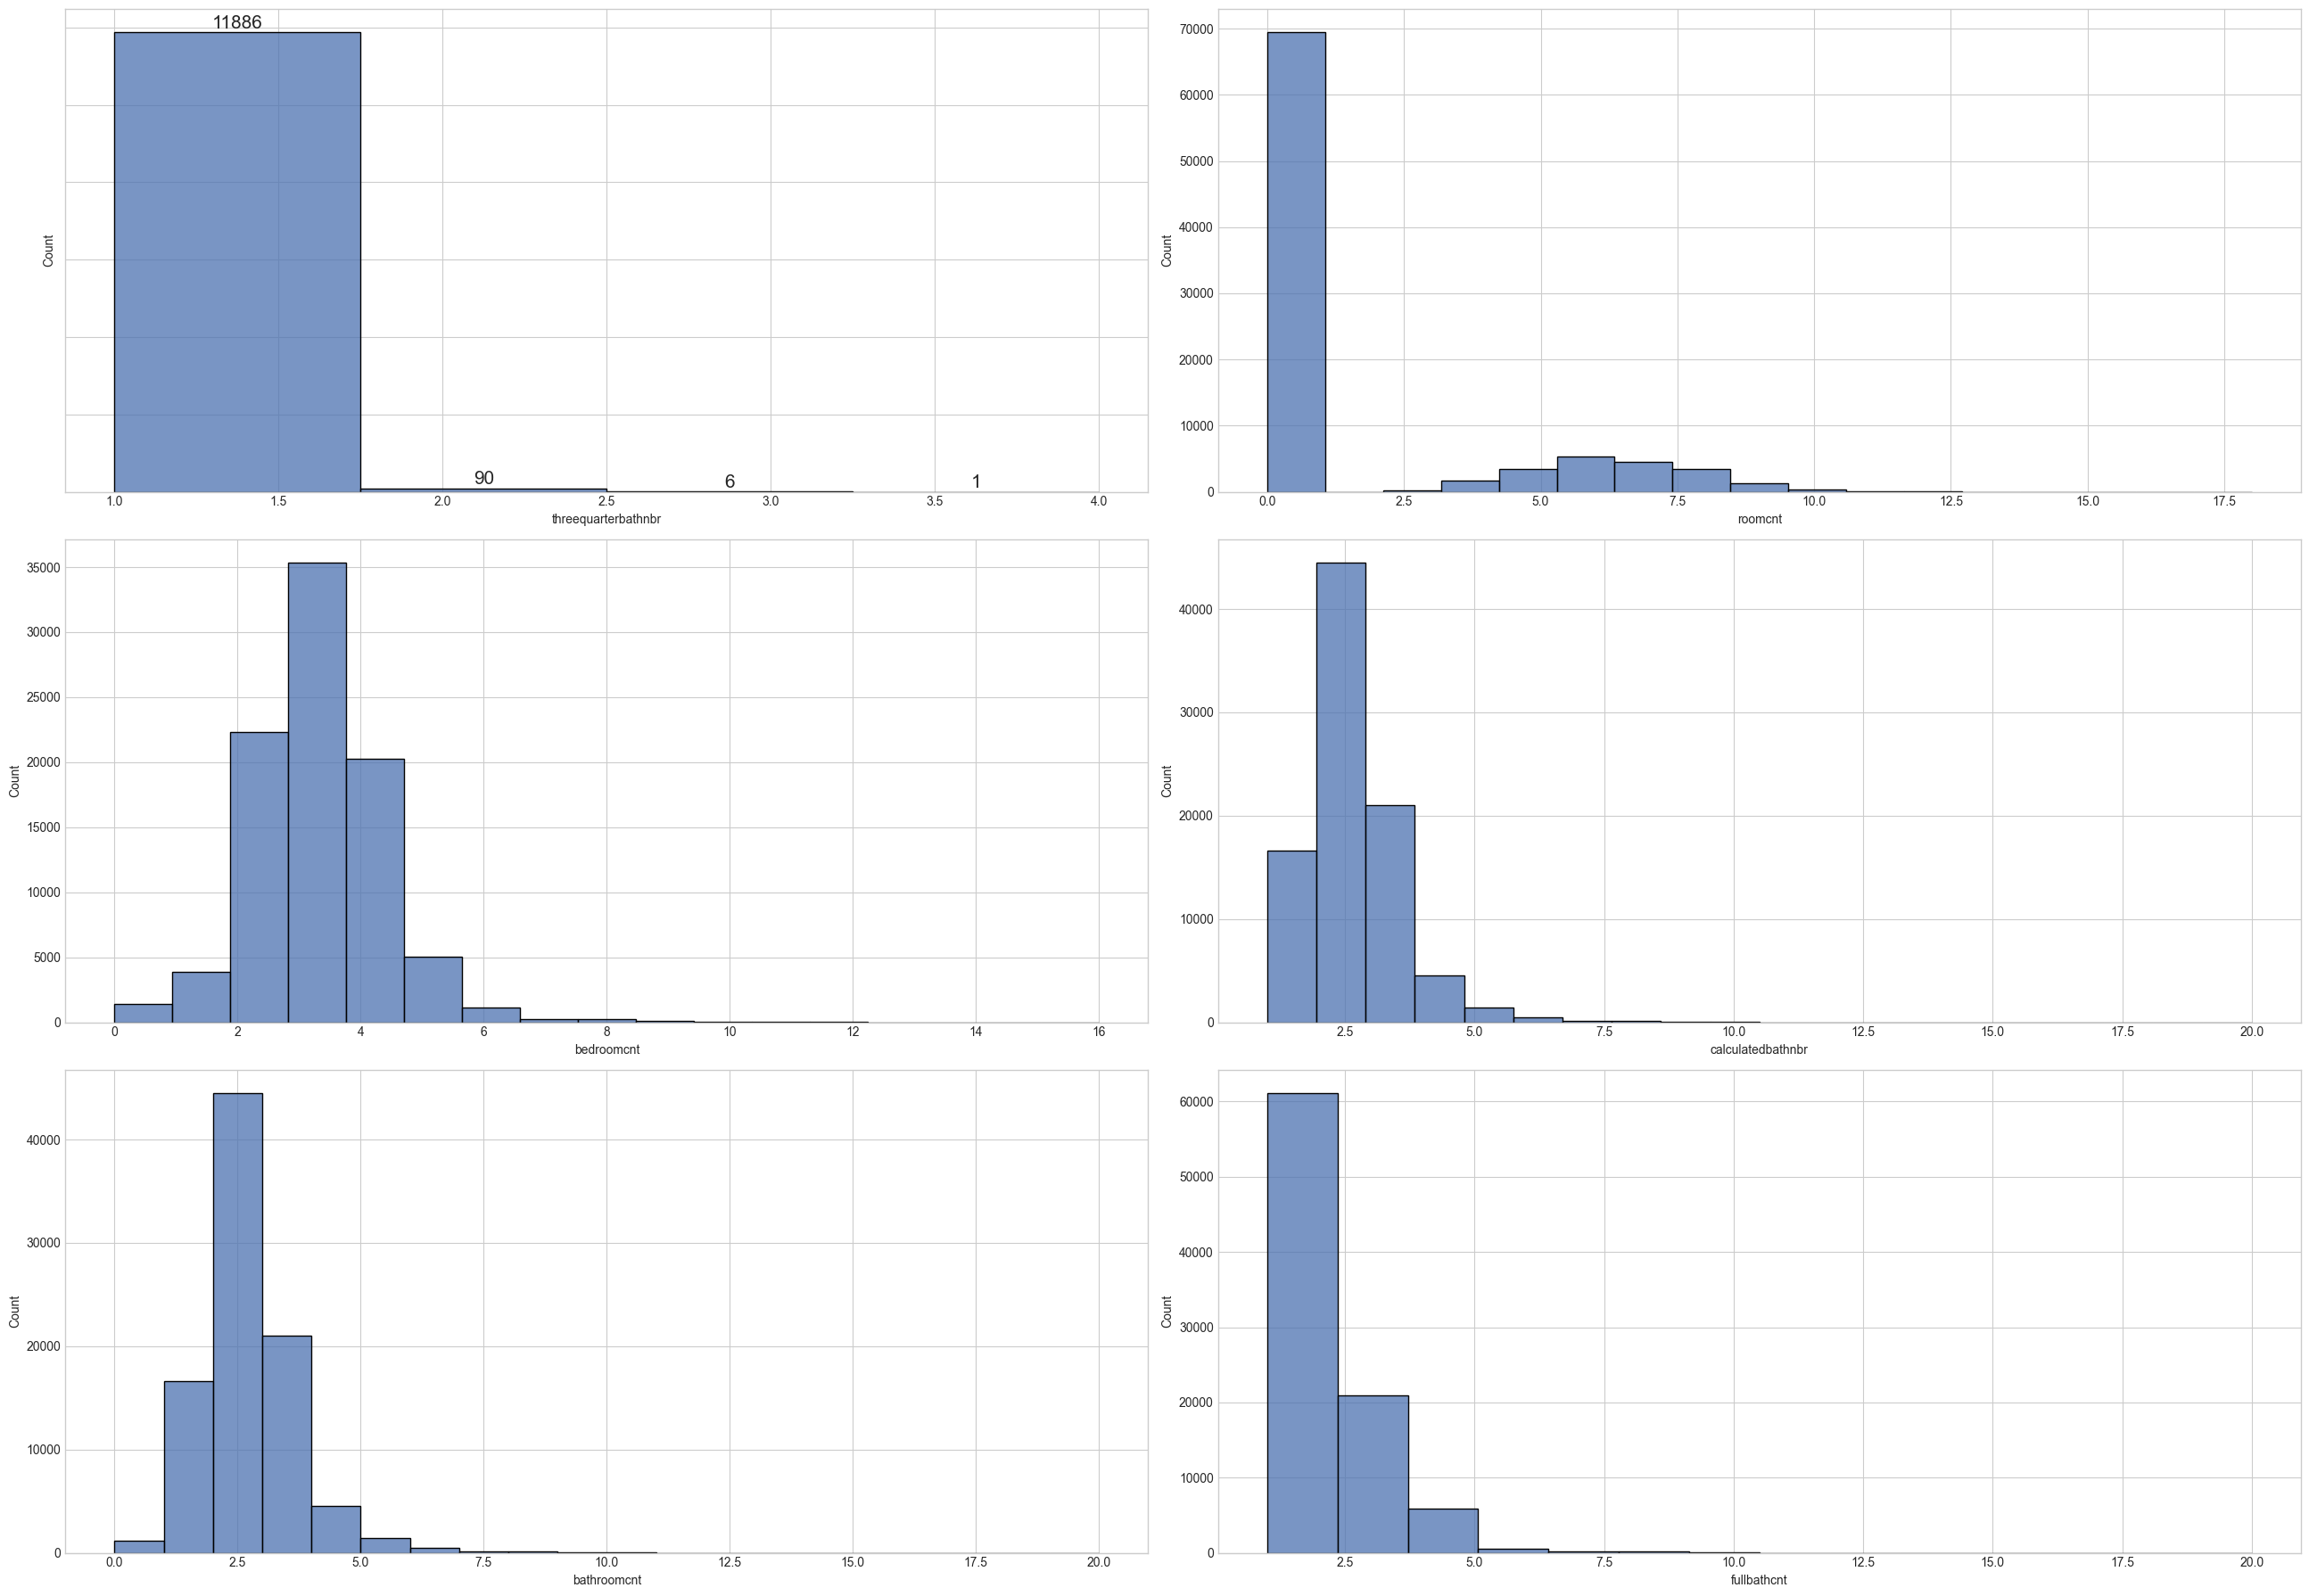

In [9]:
room_features = find_shared_cols(features_manager.room, train.columns)
cur_train = train[room_features].copy()
do_basic_visuals(cur_train, num_args={'dtype_to_convert':np.int8})

In [10]:
print(cur_train['threequarterbathnbr'].value_counts())

threequarterbathnbr
1.0    11886
2.0       90
3.0        6
4.0        1
Name: count, dtype: int64


In [11]:
k = cur_train['roomcnt'].value_counts()
k.iloc[k.index.argsort()]

roomcnt
0     69509
1         3
2        10
3       271
4      1665
5      3476
6      5333
7      4481
8      3398
9      1354
10      364
11      111
12       33
13       11
14        4
15        2
18        1
Name: count, dtype: int64

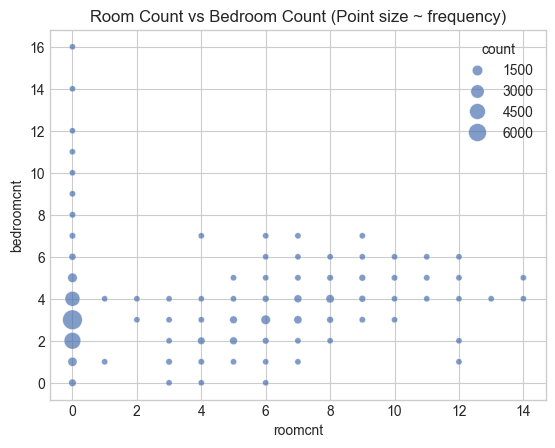

In [12]:
# TODO: How to change the point size of scatter plots according to the number of mutual occurences? How to control min/max point sizes?
counts = cur_train.sample(25000).groupby(['roomcnt', 'bedroomcnt']).size().reset_index(name='count')
g = sns.scatterplot(
    data=counts,
    x='roomcnt',
    y='bedroomcnt',
    size='count',
    sizes=(20, 200),     
    alpha=0.7
)
plt.title('Room Count vs Bedroom Count (Point size ~ frequency)')
plt.show()

In [13]:
def replace_room0_with_nan(data, col_name='roomcnt_0_is_nan'):
    data[col_name] = data['roomcnt'].apply(lambda x: np.nan if x == 0 else x)
    return data

cur_train = replace_room0_with_nan(cur_train, 'roomcnt_0_is_nan')
room_features.append('roomcnt_0_is_nan')

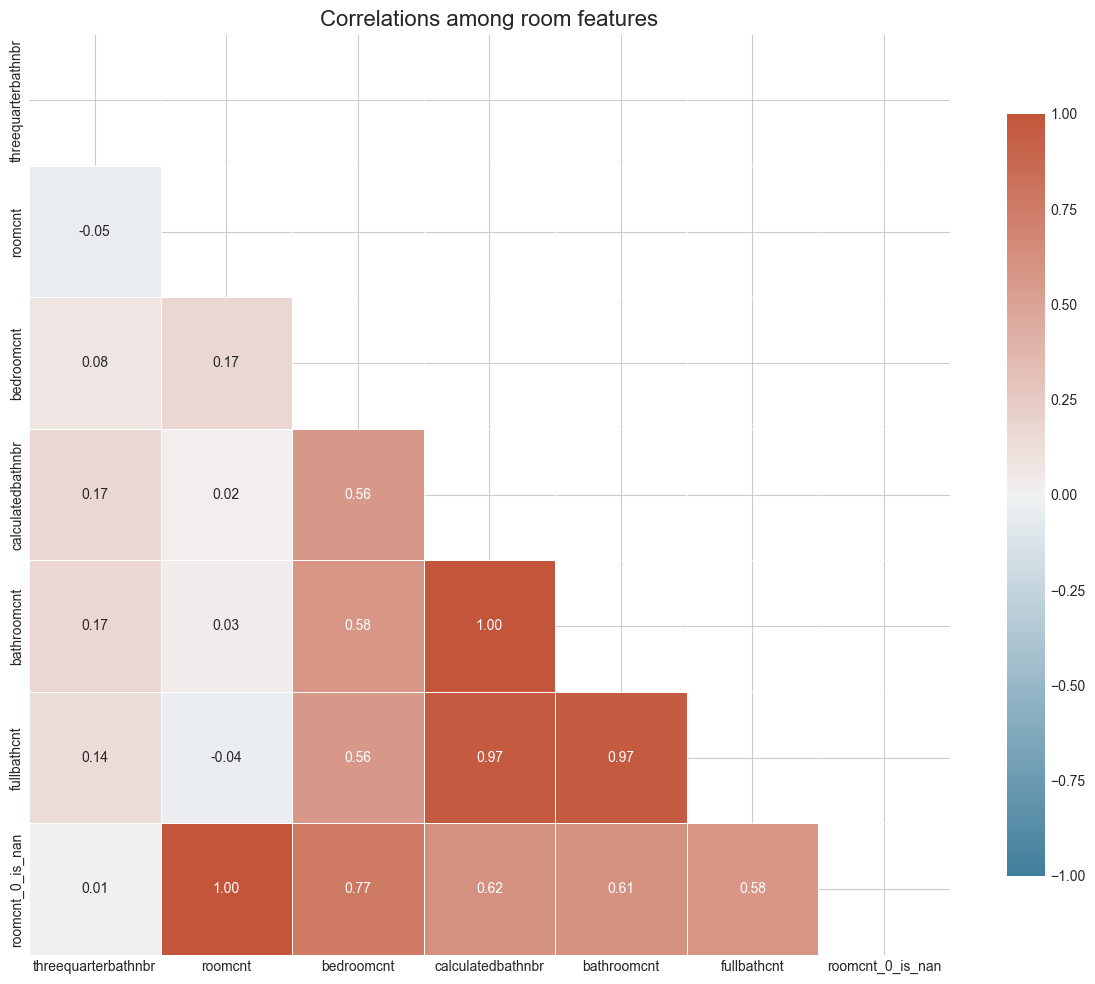

In [14]:
# sns.pairplot(cur_train[room_features].sample(20000), plot_kws={"alpha": 0.5});
plot_heatmap(cur_train[room_features].corr('spearman'), title="Correlations among room features", annot=True)

**Conclusions**:
1. Data can be converted into dtypes int8 and float8.
2. 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr' shares multinomial tailed distributions. 'fullbathcnt' - zero-inflated Poisson. Skeweness and kurtosis are big.
3. 'threequarterbathnbr' is extremely imbalanced, has many null values. 
4. 'roomcnt' seems to be erroneous. 
5. All the bathroom features strongly correlate with each other.
6. Bedroomcnt and roomcnt without 0 have solid correlations too. 

##### Area features

There are 11 features. 


'Description of the features from zillow:'

,feature,description
2,basementsqft,Finished living area below or partially below ground level
10,finishedfloor1squarefeet,Size of the finished living area on the first (entry) floor of the home
11,calculatedfinishedsquarefeet,Calculated total finished living area of the home
12,finishedsquarefeet6,Base unfinished and finished area
14,finishedsquarefeet13,Perimeter living area
15,finishedsquarefeet15,Total area
22,garagetotalsqft,Total number of square feet of all garages on lot including an attached garage
27,lotsizesquarefeet,Area of the lot in square feet
31,poolsizesum,Total square footage of all pools on property
48,yardbuildingsqft17,Patio in yard


Unique dtypes: [dtype('float32')]

Inspection per feature:


,finishedsquarefeet15,yardbuildingsqft17,lotsizesquarefeet,calculatedfinishedsquarefeet,yardbuildingsqft26,finishedfloor1squarefeet,finishedsquarefeet13,garagetotalsqft,finishedsquarefeet6,poolsizesum,basementsqft
count,3547.0,2644.0,79904.0,89371.0,95.0,6844.0,33.0,29857.0,417.0,963.0,43.0
mean,2369.269775,306.292023,25497.462891,1758.930298,310.527161,1339.56604,1404.370972,342.010498,2271.572266,517.170959,713.542358
std,985.916626,194.472488,64818.171875,847.136841,342.932983,611.185364,109.819031,249.409973,1303.733521,143.42218,437.35733
min,560.0,25.0,167.0,2.0,18.0,44.0,1056.0,0.0,257.0,28.0,100.0
25%,1648.0,180.0,5705.0,1184.0,100.0,938.0,1392.0,0.0,1106.0,420.0,407.5
50%,2104.0,260.0,7200.0,1540.0,159.0,1244.0,1440.0,433.0,1975.0,500.0,616.0
75%,2865.0,384.0,11680.25,2095.0,361.0,1613.25,1440.0,484.0,3380.0,600.0,872.0
max,5676.540039,1059.819946,461407.0,5107.600098,1255.079956,3736.139893,1578.23999,921.320007,5297.919922,952.559998,1553.319946
skewness,1.153466,1.525407,4.901038,1.550934,1.640344,1.289497,-1.393122,-0.255072,0.542356,0.554714,0.651458
kurtosis,1.080968,2.78419,26.099659,2.82197,1.508187,2.692332,2.621174,-1.061385,-0.808288,0.645584,-0.558651


Histplot visuals:


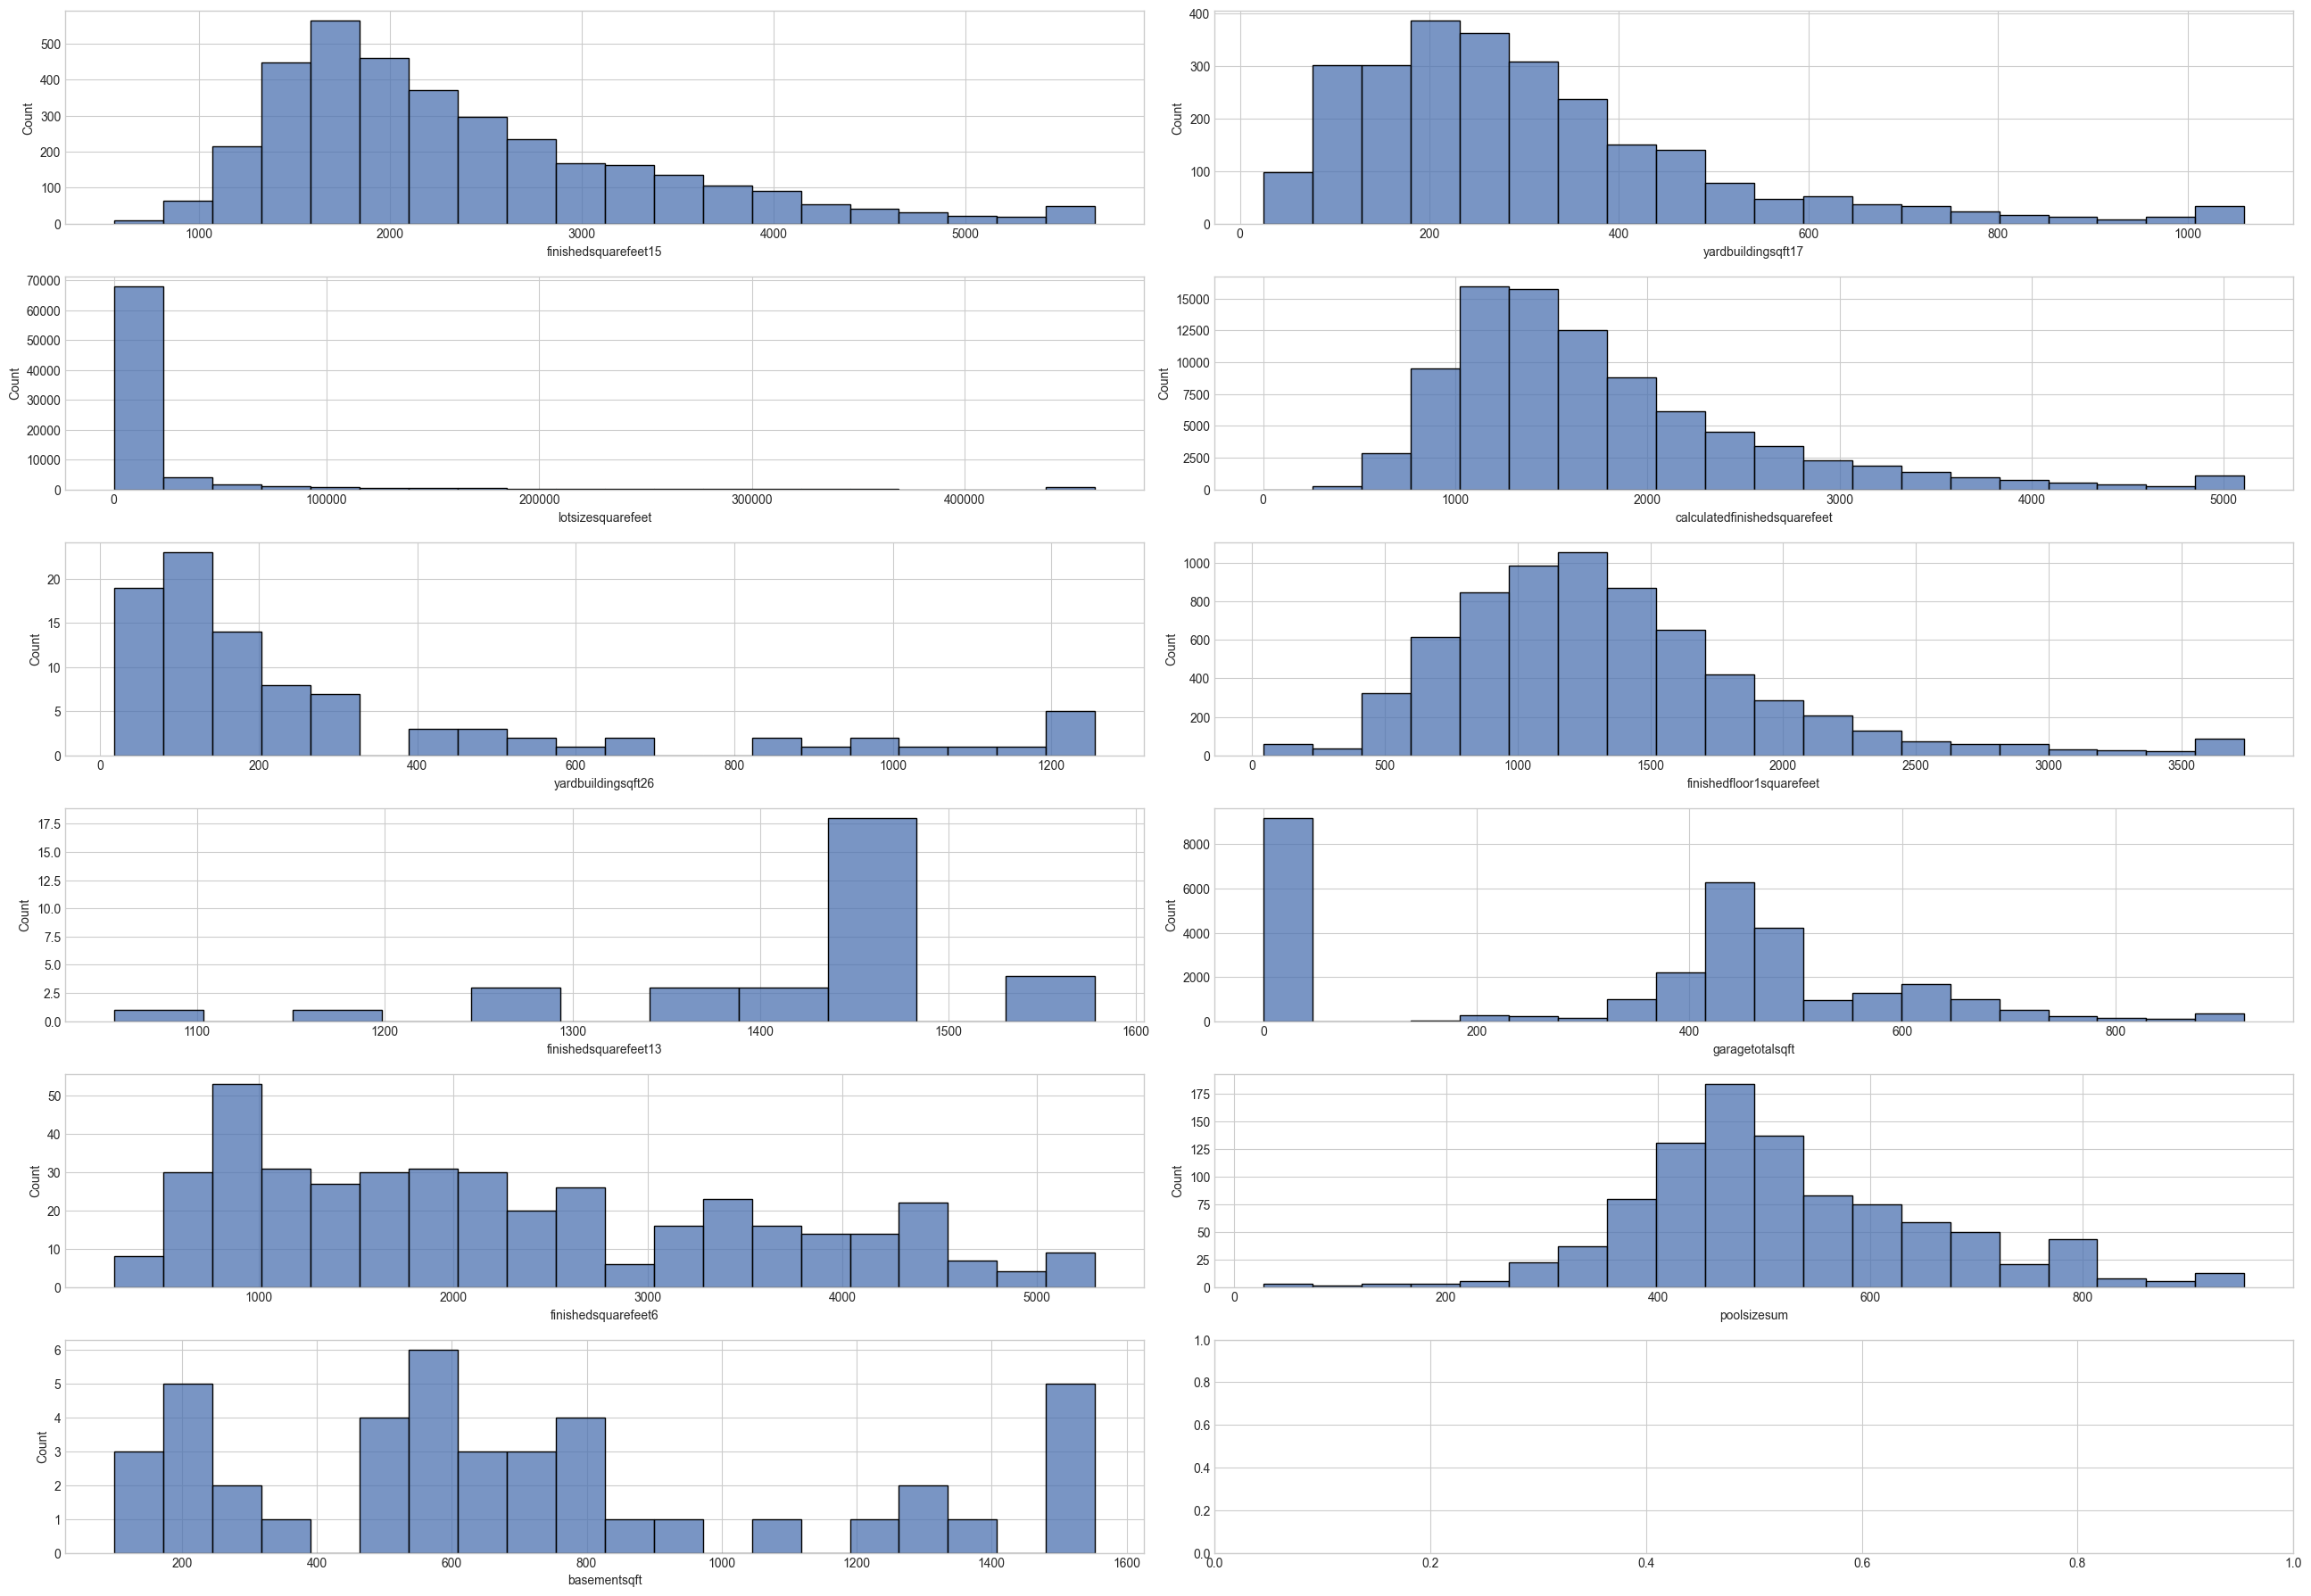

In [15]:
area_features = find_shared_cols(features_manager.area, train.columns)
cur_train = train[find_shared_cols(area_features, train.columns)]

# qq How to cap values in pandas?
# Area features are heavily skewed. We will cap large values
# for better analysis.
caps = cur_train.quantile(0.99)
cur_train_capped = cur_train.clip(upper=caps, axis=1)

do_basic_visuals(cur_train_capped, is_data_numeric=True, num_args={'dtype_to_convert':np.int32})

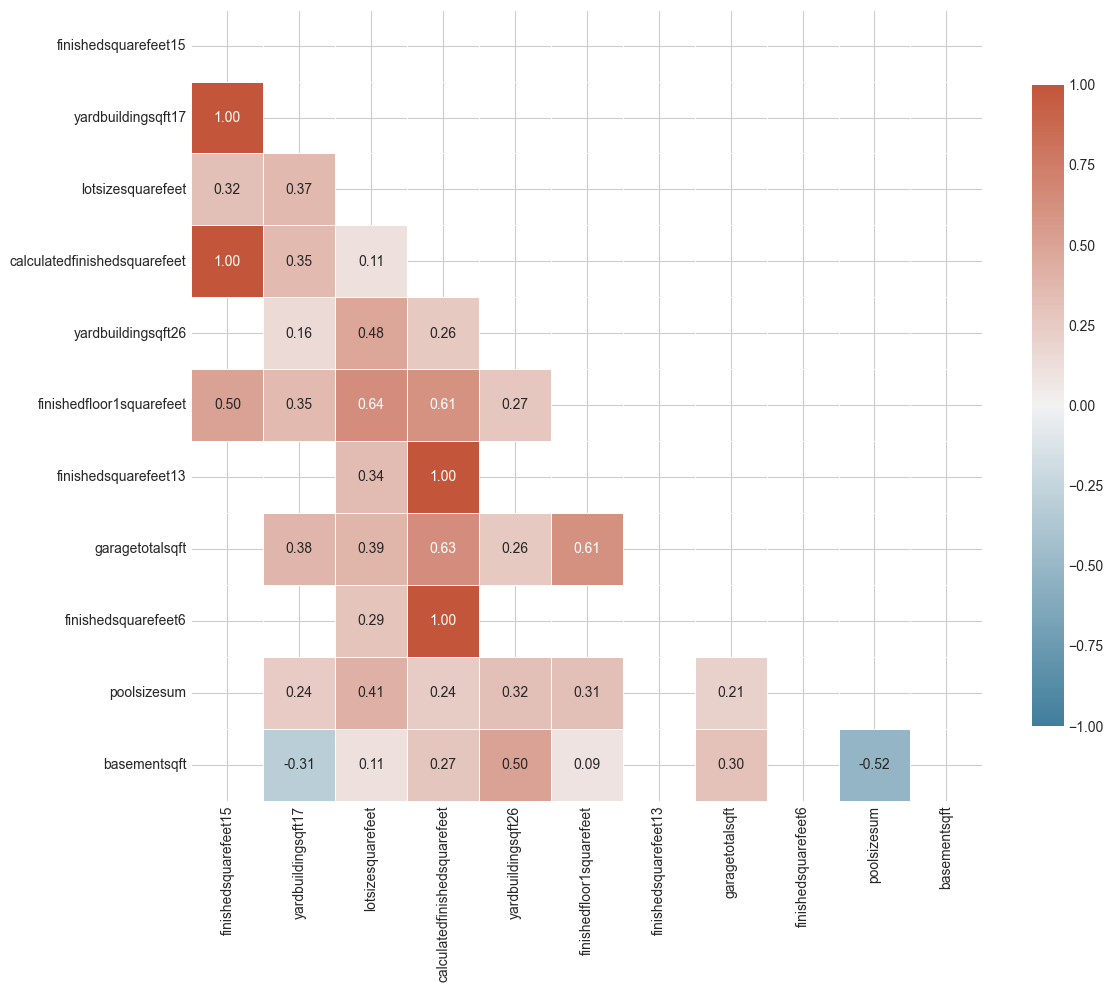

In [16]:
# TODO is the correlation flawed with such imbalanced, tailed data like this? Is removing large values or generally trying to transform into a normal distribution a good idea? Maybe, it's not because of the informaion loss?
plot_heatmap(cur_train_capped.corr('spearman'))

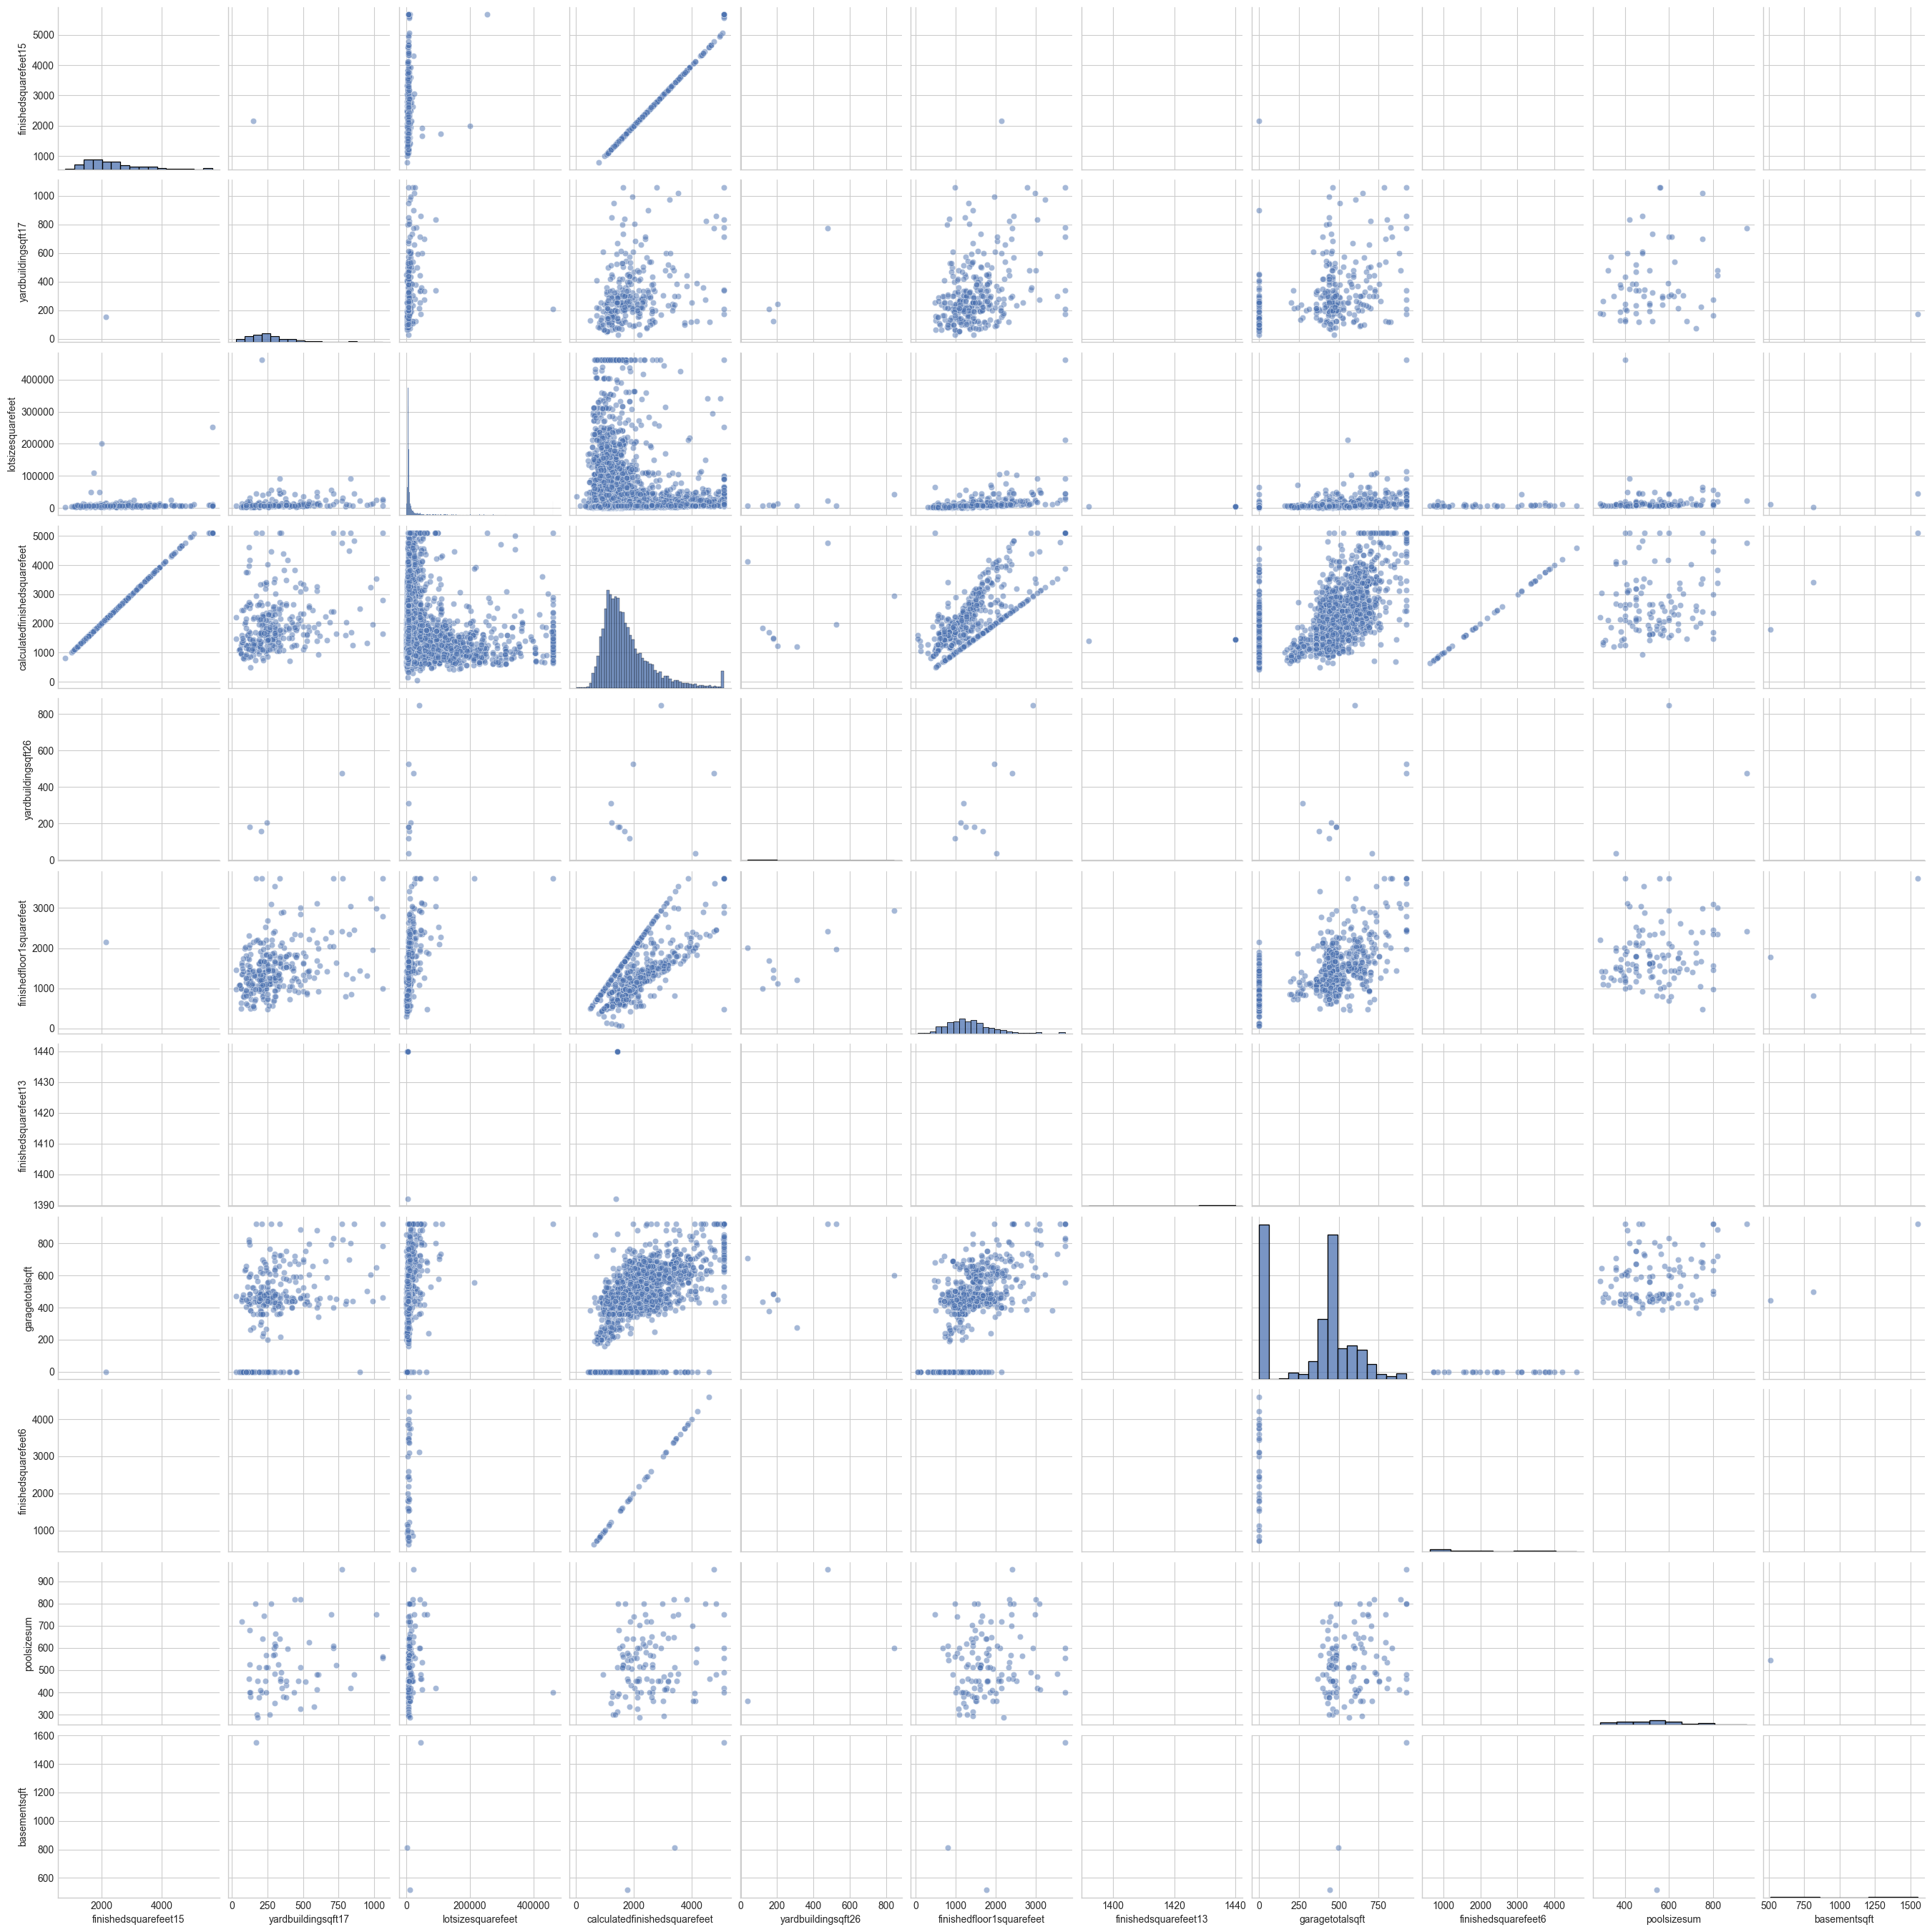

In [17]:
sns.pairplot(cur_train_capped.sample(10000), plot_kws={'alpha': 0.5});

In [18]:
print(cur_train[(
    find_shared_cols(train.columns, ['finishedfloor1squarefeet', 'finishedsquarefeet50'])
)].dropna().duplicated().value_counts())

print(cur_train[(
    find_shared_cols(train.columns, ['finishedsquarefeet12', 'calculatedfinishedsquarefeet'])
)].dropna().duplicated().value_counts())

True     4959
False    1885
Name: count, dtype: int64
True     84271
False     5100
Name: count, dtype: int64


**Conclusions**:
1. There are only 1800 values with area for pools. The min is 24. It can be assumed that those nan values are all 0. Same with 'yardbuildingsqft26'.
2. All the features are highly right tailed with some values very extreme like lotsizesquare. I think we can clip or remove these values and, maybe, to create a binary is_extreme column. Intuition tells there should be much difference in price of one extreme to another exreme. It should be definitely examined!
3. Some features contain only a handful of values. 
4. Some features can be transformed by removing extreme values. For instance, we can separate has_garage and its are with no_garage. It will also improve the distribution. 
5. Most of the distributions are normal, but very wide! Interesting pattern: every feature with reasonable amount of values follow normal distribution and others - uniform. Perhaps, that means latter will be erroneous to use because they doesn't represent the real world distribution. One counterargument is that some of the normal features are identical by nature, i.e. not independent samples.
6. 'finishedfloor1squarefeet' should be identical 'finishedsquarefeet50' and it is unless some values. I think with correlation 0.99 we can just drop any of them (if time allows data should be examined to understand). 
7. 'calculatedfinishedsquarefeet' and 'finishedsquarefeet12' are similar. Probably can delete one.  
8. Features share moderate correlations with each other. After cleaning extreme values it will be even more noticeable. 
9. 'poolsizesum' - should either clip or more probably - to remove rare cases, but 'finishedfloor1squarefeet' - clipped.

##### Property amneticies

There are 9 features. 


'Description of the features from zillow:'

,feature,description
8,decktypeid,Type of deck (if any) present on parcel
18,fireplacecnt,Number of fireplaces in a home (if any)
19,fireplaceflag,Is a fireplace present in this home
21,garagecarcnt,Total number of garages on the lot including an attached garage
23,hashottuborspa,Does the home have a hot tub or spa
30,poolcnt,Number of pools on the lot (if any)
32,pooltypeid10,Spa or Hot Tub
33,pooltypeid2,Pool with Spa/Hot Tub
34,pooltypeid7,Pool without hot tub


Unique dtypes: [dtype('bool') Int8Dtype() dtype('int64')]

Inspection per feature:


,fireplacecnt,garagecarcnt,fireplaceflag,hashottuborspa
count,90026.0,90026.0,90026.0,90026.0
mean,0.126497,0.600982,0.002422,0.026226
std,0.399047,0.92242,0.04915,0.159807
min,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0
75%,0.0,2.0,0.0,0.0
max,5.0,24.0,1.0,1.0
skewness,3.755966,1.472717,20.247948,5.929465
kurtosis,17.166845,6.919814,407.988456,33.159294


Histplot visuals:


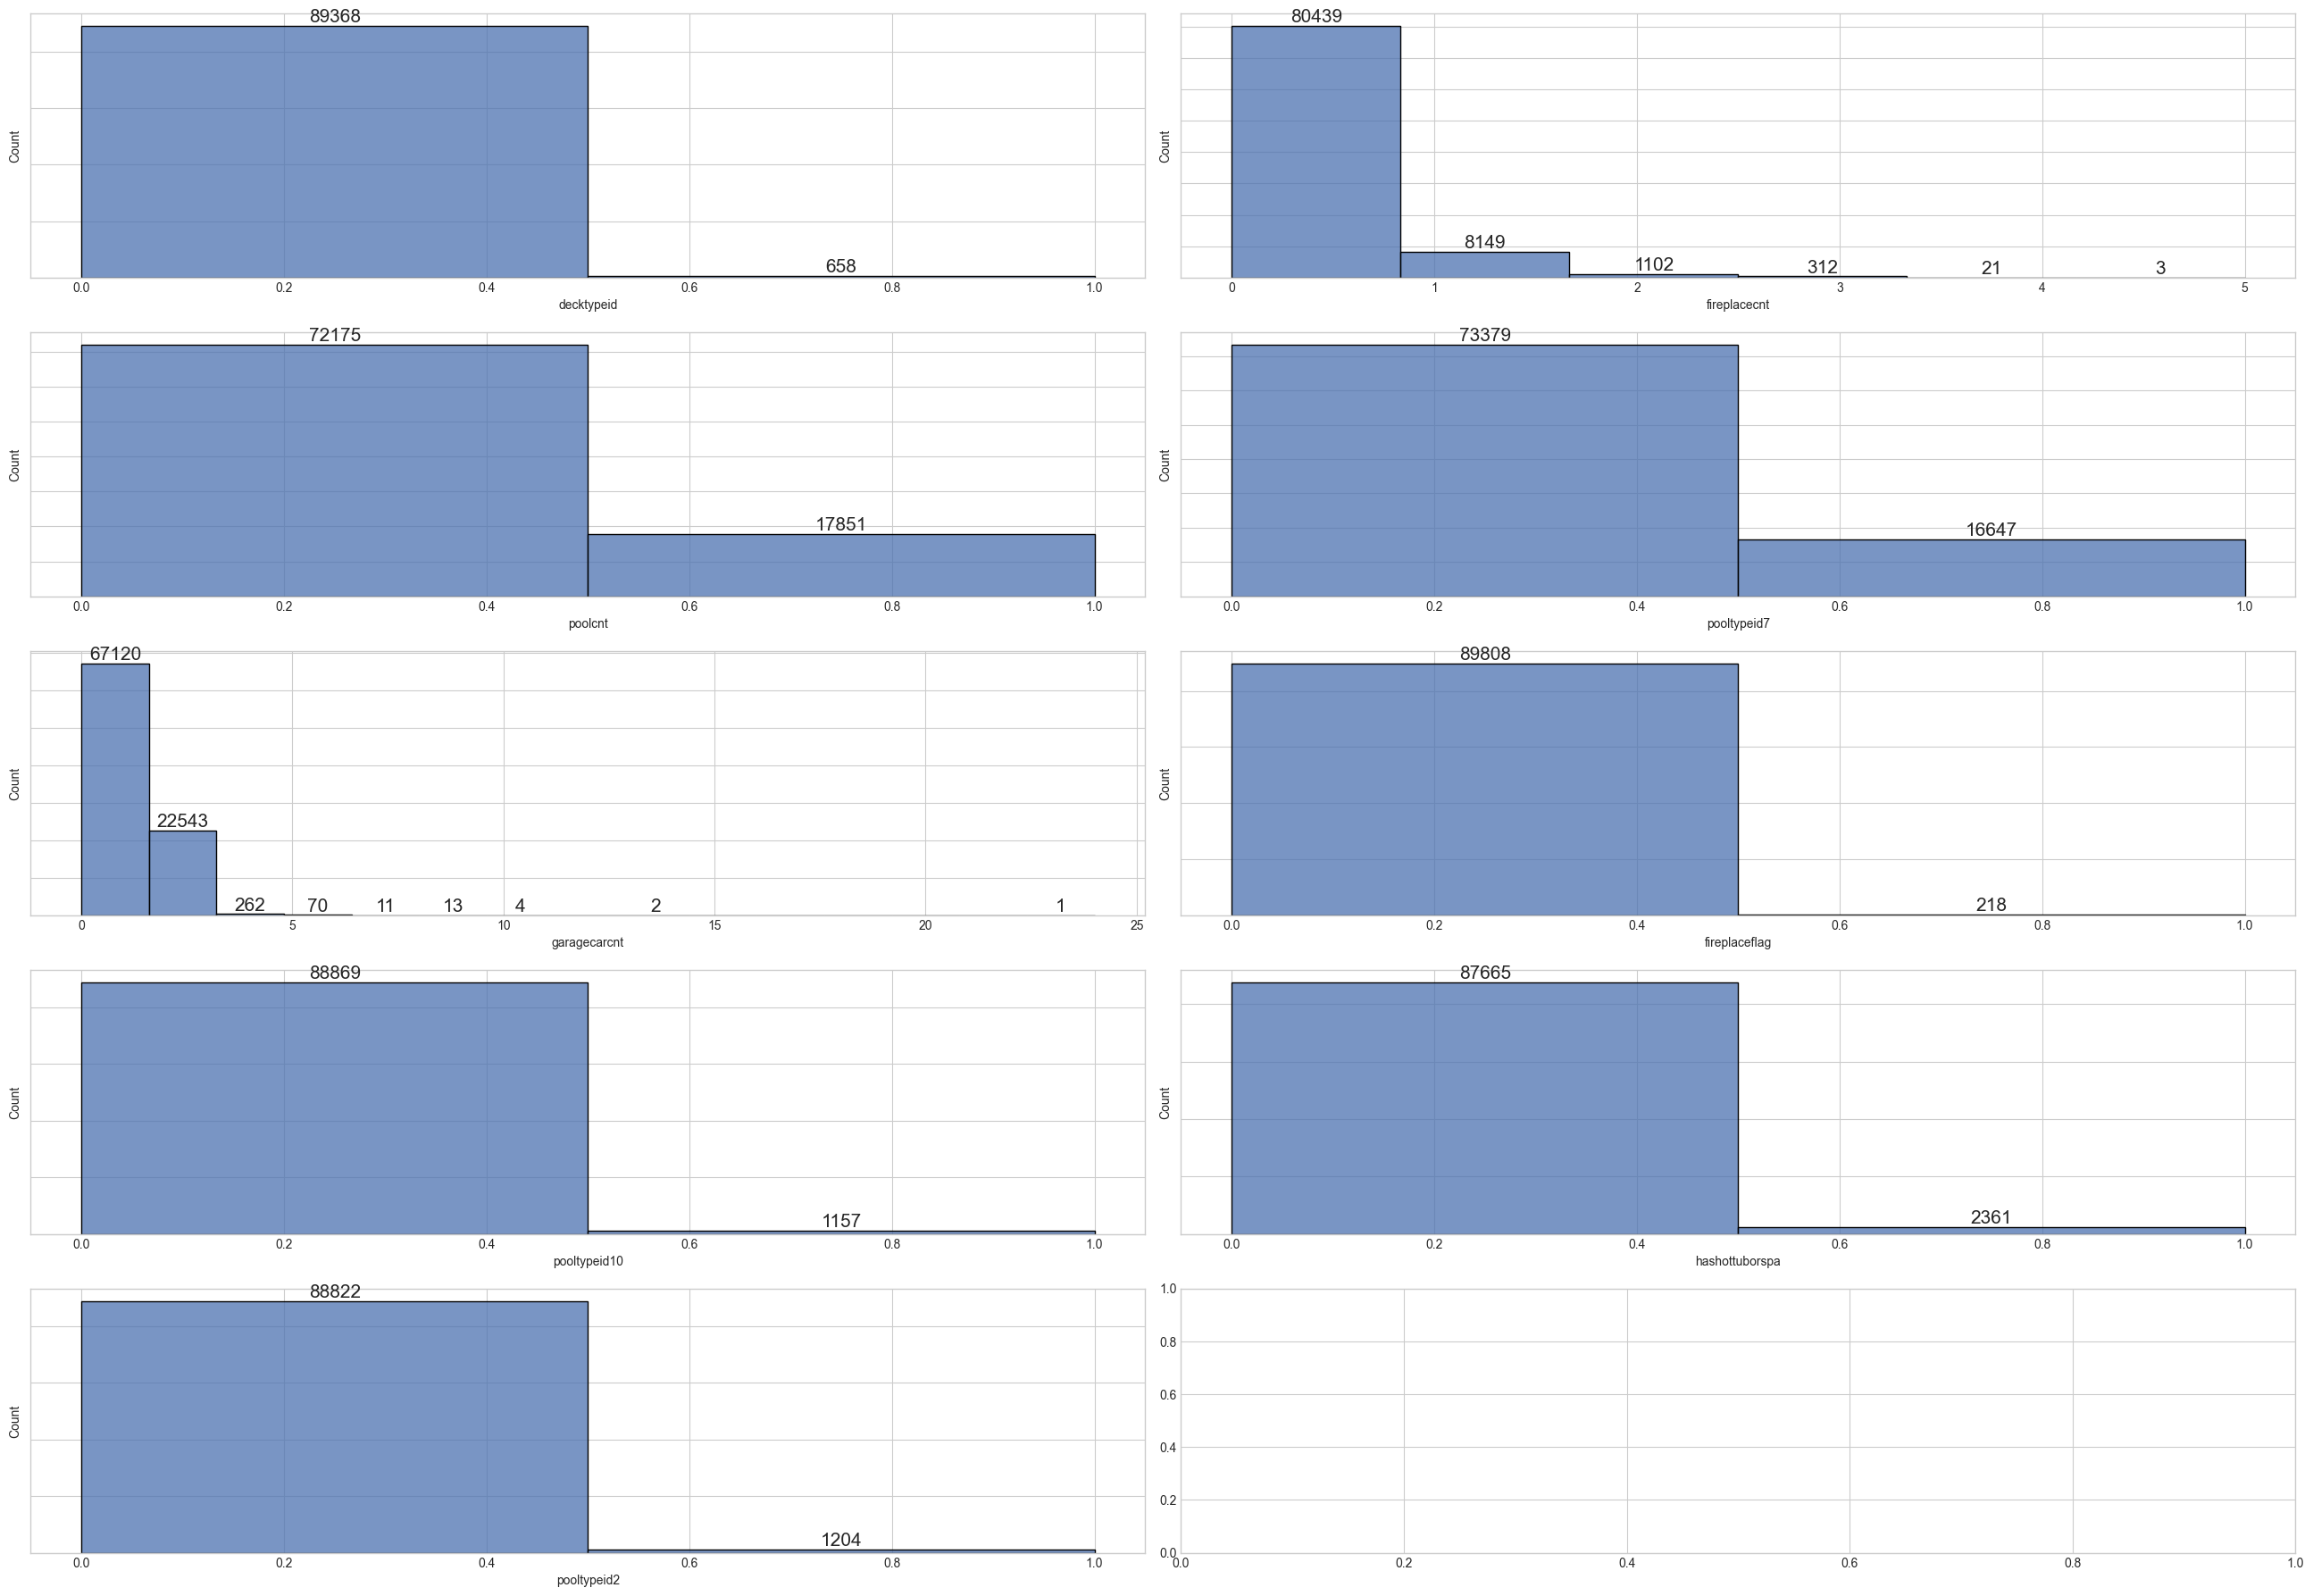

In [19]:
property_features = find_shared_cols(features_manager.property_amenities, train.columns)
cur_train = train[property_features].copy()

# The features are binary with nan values meaning "not present".
cur_train.fillna(0, inplace=True)

# 'fireplaceflag', 'hashottuborspa' are boolean. Transforming them to visualise properly.
cur_train['fireplaceflag'] = cur_train.fireplaceflag.apply(lambda x: 1 if x else 0)
cur_train['hashottuborspa'] = cur_train.hashottuborspa.apply(lambda x: 1 if x else 0)

do_basic_visuals(cur_train, 
                 num_args={'dtype_to_convert': np.int8}, 
                 plot_kws={'to_annotate_counts': True})

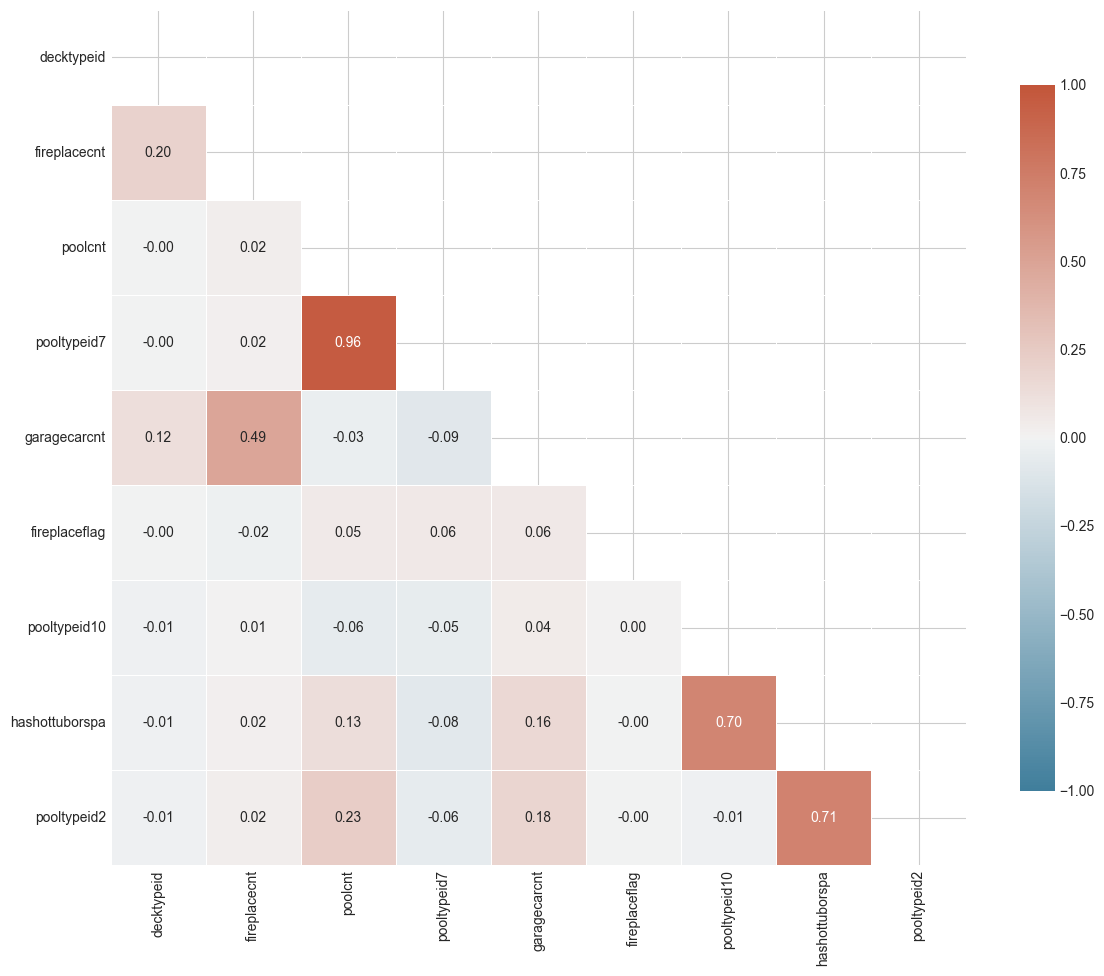

In [20]:
# TODO: is it okay to check correlations of bool to others?
plot_heatmap(cur_train.corr('kendall'))

**Conclusions**:
1. All pool types are variations of pool design: with spa, hot tub, etc. Thus the missing values can be imputed with 0 (=False).
2. Min and maxes are low. Dtypes should be modified. 
3. Missing values can be easily imputed because most of them are binary (nan means False). Overall missing fractions are tolerable. 
4. All the features imbalanced. It can potentially result into noise rather than signal. It includes low counts of values of garagecnt and fireplacecnt.
5. Fireplacecnt is correlated with presence of deck and garage, but they aren't correlated with pool presence. 

##### Location

In [21]:
def clean_censusandblock(array):
    return array.apply(lambda x: np.nan if len(str(
        np.float64(x) # Converting to float for a unified cleaning approach.
    )) == 17 else x)

There are 17 features. 


'Description of the features from zillow:'

,feature,description
17,fips,Federal Information Processing Standard code - see https://en.wikipedia.org/wiki/FIPS_county_code for more details
25,latitude,Latitude of the middle of the parcel multiplied by 10e6
26,longitude,Longitude of the middle of the parcel multiplied by 10e6
40,regionidcounty,County in which the property is located
41,regionidcity,City in which the property is located (if any)
42,regionidzip,Zip code in which the property is located
43,regionidneighborhood,Neighborhood in which the property is located


Unique dtypes: [dtype('float64') Int16Dtype() dtype('float32')]

Inspection per feature:


,census_fips,census_main_id,regionidneighborhood,regionidzip,regionidcounty,raw_census_suffix_id,fips,raw_census_group_id,latitude,regionidcity,census_group_id,raw_census_group_number_id,raw_census_fips,raw_census_main_id,census_group_number_id,longitude,census_suffix_id
count,89178.0,89178.0,35900.0,89991.0,90026.0,80982.0,90026.0,76072.0,90026.0,88227.0,89178.0,89769.0,89779.0,89779.0,89178.0,90026.0,89178.0
mean,6048.848416,3090.651943,190582.307827,96586.260426,2525.499645,8.14034,6048.874947,2.064176,34005520.0,33763.506625,2.069591,29.117535,6048.877343,3089.157231,10.744713,-118198904.0,8.153805
std,20.633121,2801.649257,166176.794865,3666.340284,805.618747,12.039574,20.671391,1.120383,264991.65625,46695.160592,1.121753,67.759456,20.673063,2804.315848,18.933731,360659.1875,12.048236
min,6037.0,1.0,6952.0,95982.0,1286.0,0.0,6037.0,0.0,33339296.0,3491.0,1.0,1.0,6037.0,1.0,0.0,-119447864.0,0.0
25%,6037.0,636.0,46736.0,96193.0,1286.0,1.0,6037.0,1.0,33811690.0,12447.0,1.0,4.0,6037.0,636.0,2.0,-118411712.0,1.0
50%,6037.0,2167.0,118887.0,96393.0,3101.0,2.0,6037.0,2.0,34021544.0,25218.0,2.0,8.0,6037.0,2161.0,6.0,-118173432.0,2.0
75%,6059.0,5325.75,274800.0,96987.0,3101.0,10.0,6059.0,3.0,34172800.0,45457.0,3.0,18.0,6059.0,5323.0,13.0,-117921586.0,10.0
max,6111.0,9800.0,764167.0,399675.0,3101.0,61.0,6111.0,9.0,34816008.0,396556.0,9.0,902.0,6111.0,9800.0,910.0,-117554928.0,61.0
skewness,2.078855,0.759861,1.399689,81.615071,-0.767088,2.018266,2.075105,1.095854,0.263276,6.446265,1.088556,4.365005,2.074789,0.762585,11.882309,-0.651096,2.011487
kurtosis,3.621339,-0.562867,2.691667,6744.240496,-1.301615,3.664039,3.596779,1.199996,-0.096701,46.710861,1.18012,22.157742,3.595234,-0.56028,304.544692,0.356172,3.609976


Histplot visuals:


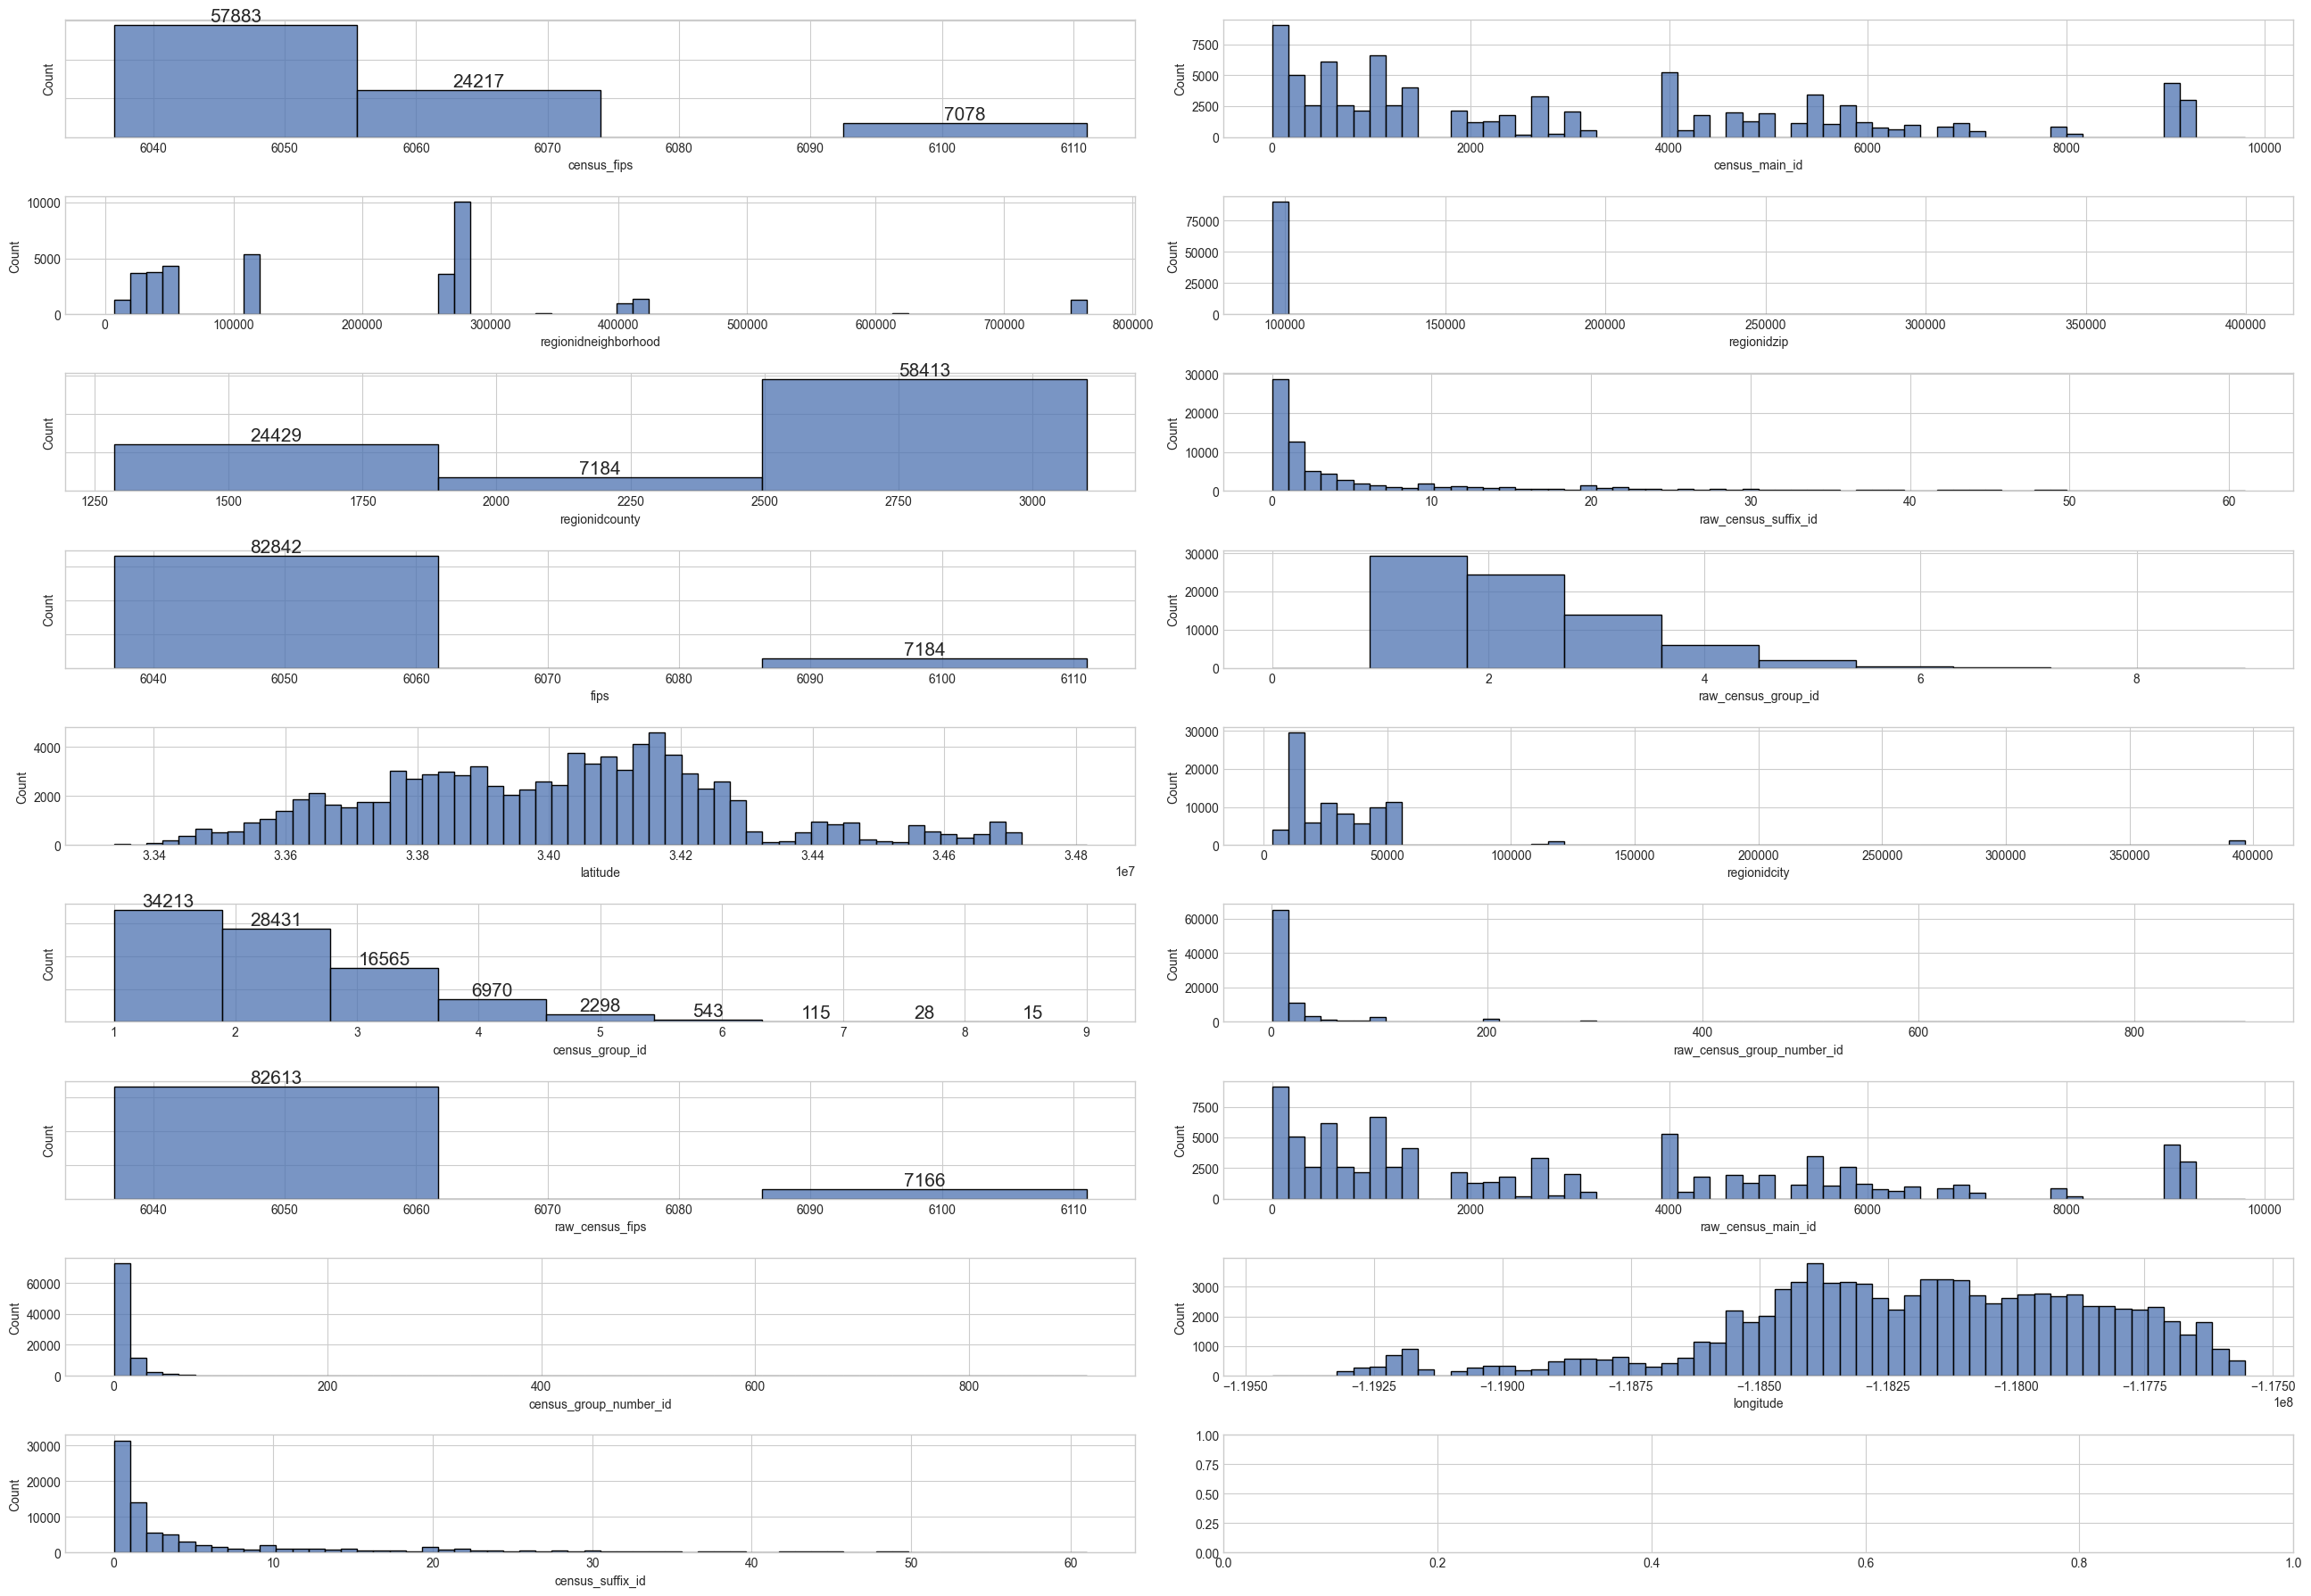

In [38]:
# More on geographical notations: https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html.
# Our state + country (fips) has only 4 digit (not 5)!

initial_census_feats_present = all(c in train.columns for c in ['rawcensustractandblock', 'censustractandblock'])
broken_census_features = list(FeaturesDtypeConversionConfig_v1().dtype_break_down_mapping['censuses'].keys())
location_features = features_manager.location

if initial_census_feats_present:
        cur_train = train[location_features].copy()
        initial_census_feats_present = True
        census_columns = ['rawcensustractandblock', 'censustractandblock']
        print("Unique lengths of census codes: ")
        t = cur_train[census_columns].dropna().map(lambda x: len(str(x)))
        print(t.apply(lambda x: x.unique()))
        print("Number of incomplete codes in rawcensus:", 
                t[t['rawcensustractandblock'] != 15].shape[0])

        # Cleaning censustractandblock
        print("Number of rows with code length 17:", t[(t == 17).any(axis=1)].shape[0])
        cur_train['censustractandblock'] = clean_censusandblock(cur_train['censustractandblock'])

        # Breaking down censuses
        cur_train = break_down_censuses(cur_train)
        cur_train.drop(census_columns, axis=1, inplace=True)
else:
        cur_train = train[find_shared_cols(
                broken_census_features + location_features, train.columns)].copy()

do_basic_visuals(cur_train, num_args={'dtype_to_convert': np.int32}, plot_kws={'bins': 60})

In [23]:
if initial_census_feats_present:
    print("Cen fips to fips:", set(cur_train['census_fips'].unique()) ^ 
                                    set(cur_train['fips'].unique()))
    print("Raw cen fips to fips:", set(cur_train['raw_census_fips'].unique()) ^ 
                                    set(cur_train['fips'].unique()))

In [24]:
breaked_census_columns = cur_train.columns[cur_train.columns.str.startswith('census_')]
breaked_rawcensus_columns = cur_train.columns[cur_train.columns.str.startswith('raw_census_')]

for c, rawc in zip(breaked_census_columns, breaked_rawcensus_columns):
    not_matched_count = cur_train[cur_train[c] != cur_train[rawc]].shape[0]
    max_of_non_nan = max(cur_train[c].dropna().shape[0], cur_train[rawc].dropna().shape[0])
    perc = np.round(not_matched_count / max_of_non_nan * 100, decimals=2)
    print(f"Percentage of differencies in {c}:", perc)

The differences are non-negligeable, but we should still keep in mind that raw census may not have last ids whatsoever. Probably this is the reason why we have great increase in percentage of suffix, group and group number.
The huge number of imcomplete raw censuses is bad too. 

In [25]:
# TODO wtf vscode can't work properly? My memory usage is big, but there is still space. Processors are working only at 40% max. What is it so slow like the weights is accumulating and accumulating with every second I spend here working?
# does the size of code in notebooks matter?
cur_train['regionidzip'].value_counts().tail(15)

regionidzip
95991.0     18
97119.0     17
97324.0     16
399675.0    13
95995.0     12
96148.0     11
97108.0      6
96329.0      5
96002.0      4
96039.0      3
96500.0      2
96034.0      1
96467.0      1
96226.0      1
97111.0      1
Name: count, dtype: int64

**Conclusions**:
1. 'fips' and 'regioncountry' are imbalanced categorical columns. 
2. latitude and longitude are normally, but widely distributed with heavy tails. It seems like they don't contain extreme outliers. 
3. Counts of values without missingness is suspected. There is probably a correlation of missingness among some features.
4. The nature of 'rawcensustractandblock' and 'censustractandblock' suggets these features can be grouped and used as categorical columns. If it's possible to dO (maybe on first few numbers or to divide the code), then we can use the features, otherwise they should be probably dropped because of the high cardinality which creates too much noise. 
5. Distribution shows that values of region features are clustered around specific points too while others occur very little amont of times. So they may try to group them too.
6. We should change dtypes for all columns.
7. Raw and cleaned censuses are mostly similar, but each has some strange values. Anyway, if these features matter then they should be carefully examined in order to identify valid and erroneous ones. 

##### Property type

There are 8 features. 


'Description of the features from zillow:'

,feature,description
0,airconditioningtypeid,Type of cooling system present in the home (if any)
1,architecturalstyletypeid,"Architectural style of the home (i.e. ranch, colonial, split-level, etc)"
5,buildingqualitytypeid,Overall assessment of condition of the building from best (lowest) to worst (highest)
6,buildingclasstypeid,"The building framing type (steel frame, wood frame, concrete/brick)"
24,heatingorsystemtypeid,Type of home heating system
36,propertylandusetypeid,Type of land use the property is zoned for
45,storytypeid,"Type of floors in a multi-story house (i.e. basement and main level, split-level, attic, etc.). See tab for details."
46,typeconstructiontypeid,What type of construction material was used to construct the home


Unique dtypes: [Int8Dtype() dtype('float32') dtype('bool')]

Inspection per feature:


,airconditioningtypeid,heatingorsystemtypeid,propertylandusetypeid,architecturalstyletypeid,typeconstructiontypeid,buildingqualitytypeid
count,28715.0,55930.0,90026.0,259.0,297.0,57205.0
mean,1.814069,3.925818,261.834595,7.23166,6.010101,5.565405
std,2.970041,3.683395,5.183711,2.726628,0.438709,1.900276
min,1.0,1.0,31.0,2.0,4.0,1.0
25%,1.0,2.0,261.0,7.0,6.0,4.0
50%,1.0,2.0,261.0,7.0,6.0,7.0
75%,1.0,7.0,266.0,7.0,6.0,7.0
max,13.0,24.0,275.0,21.0,13.0,12.0
skewness,3.447541,3.344965,-18.355633,3.666542,13.102763,-0.242304
kurtosis,9.993647,14.796141,775.841309,18.287456,222.180985,-0.089053


Histplot visuals:


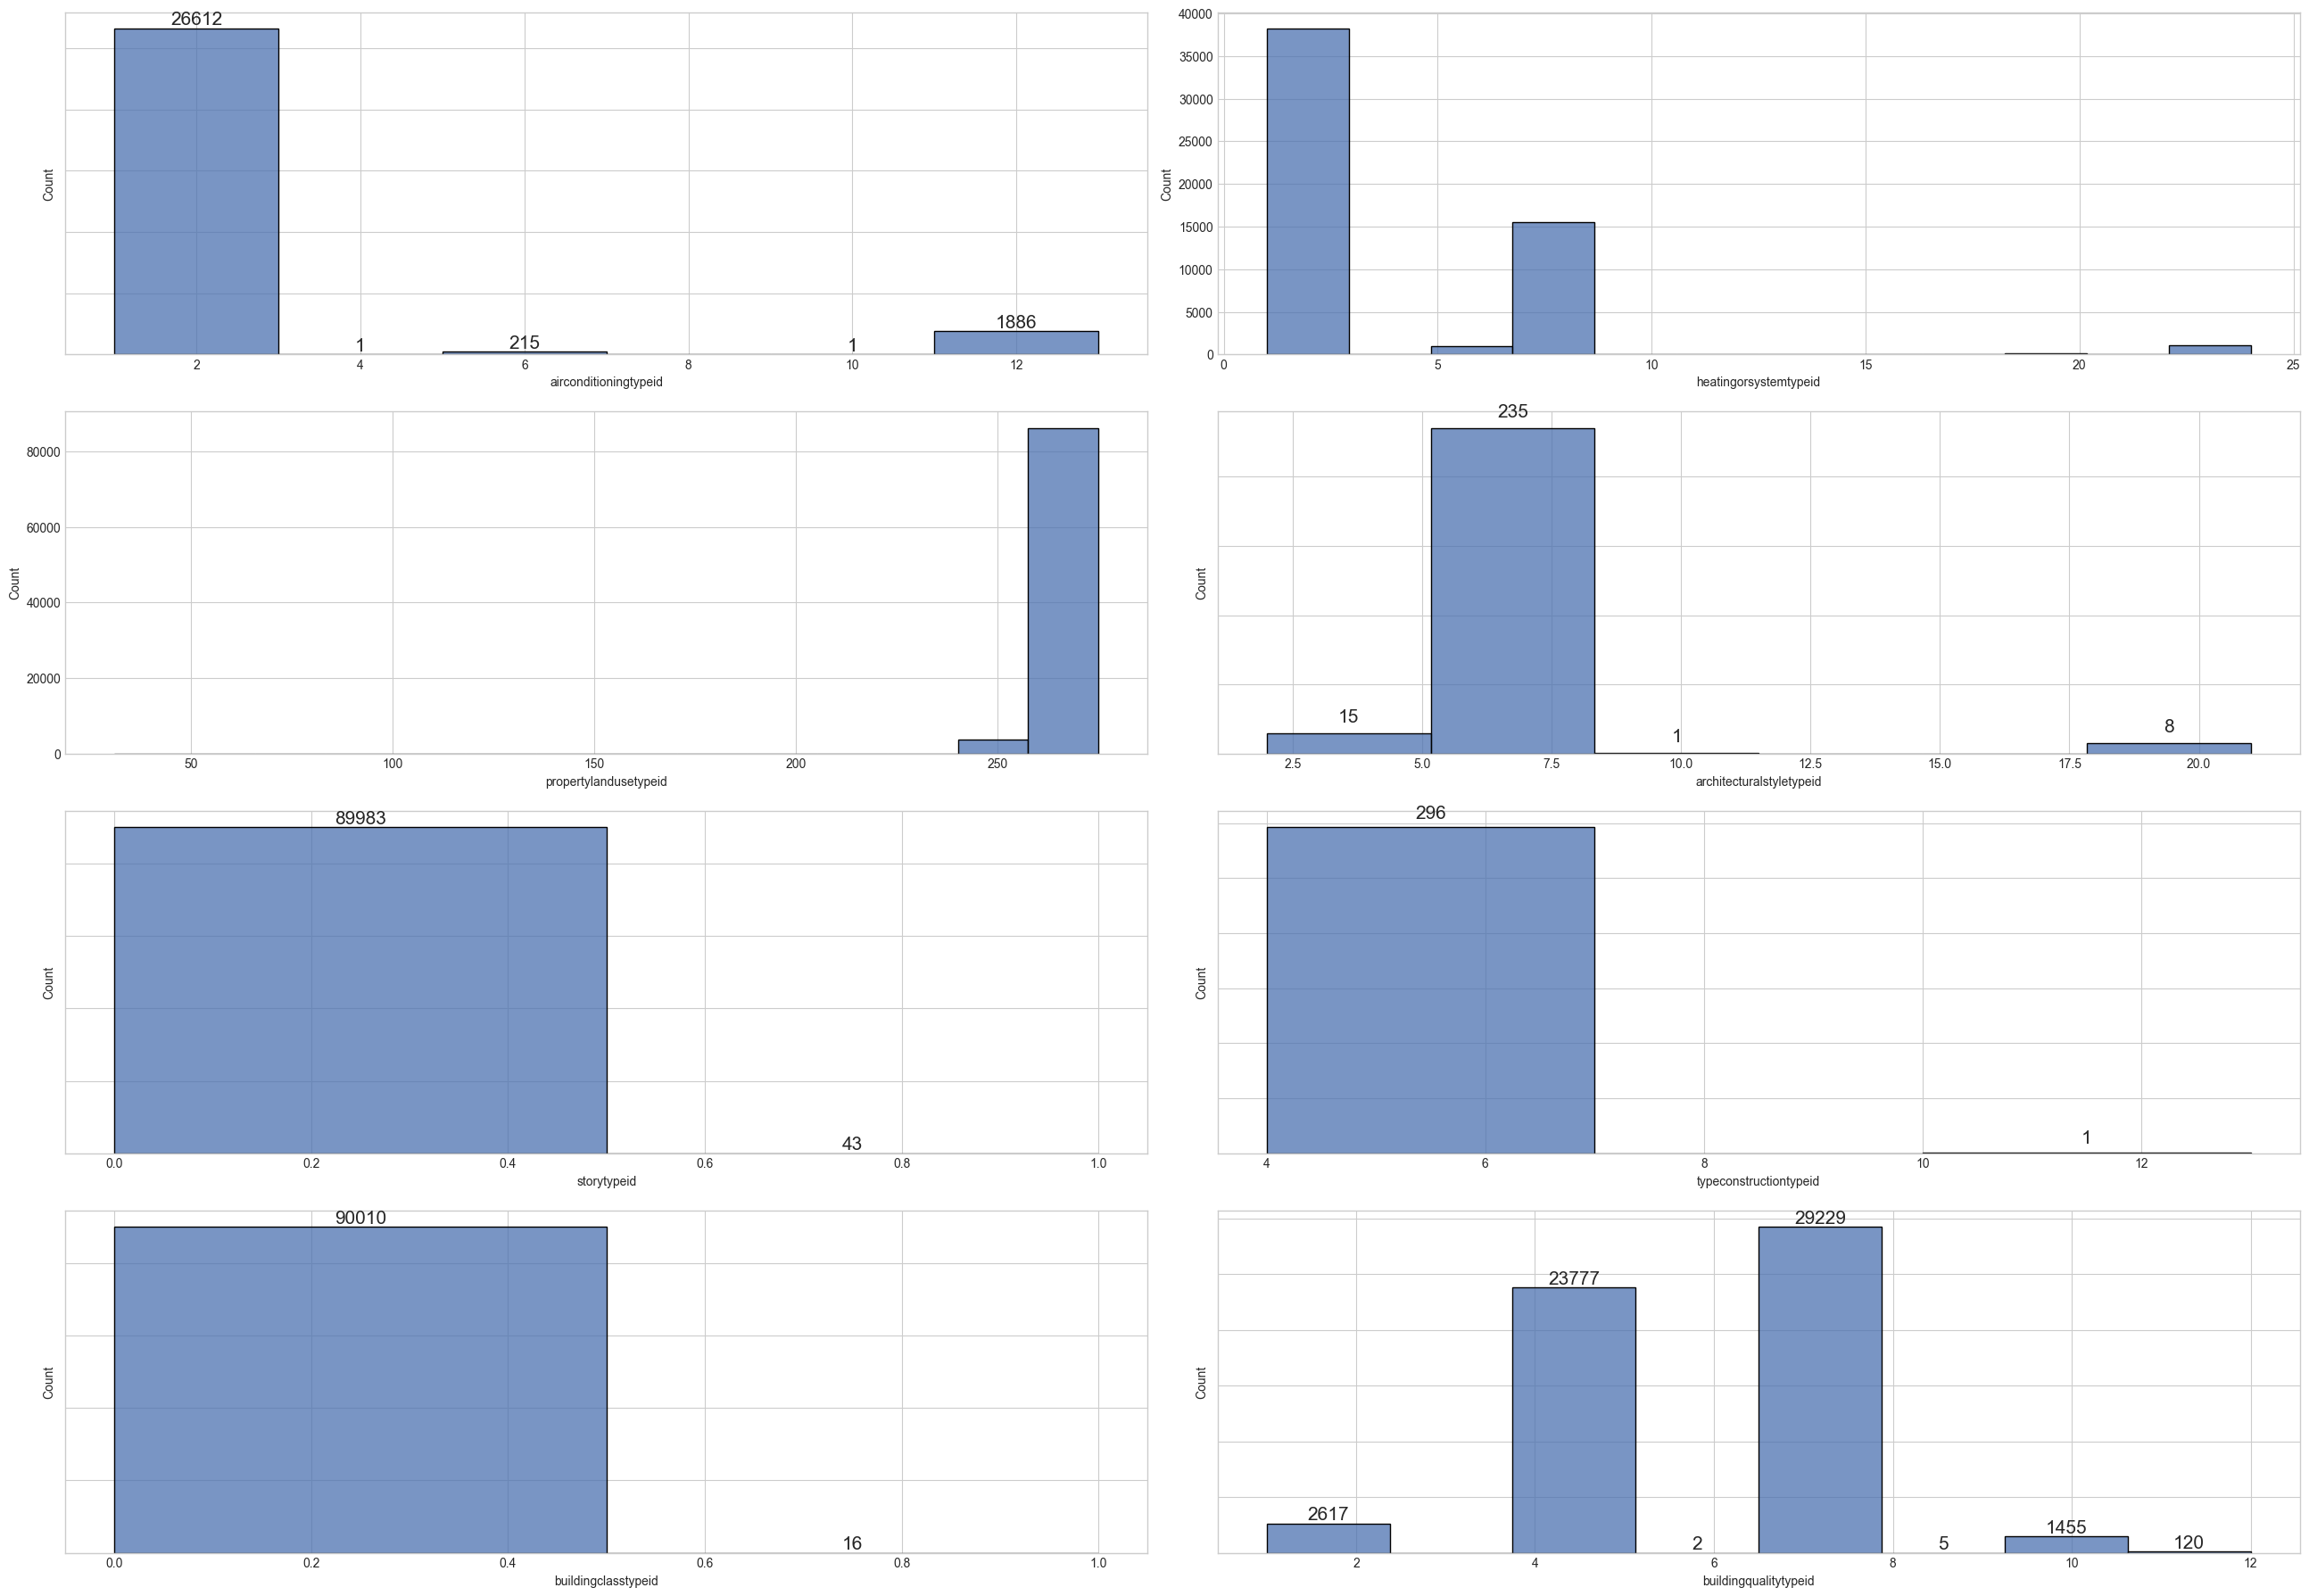

In [26]:
prop_type_features = find_shared_cols(features_manager.property_type, train.columns)
cur_train = train[prop_type_features]
do_basic_visuals(cur_train, num_args={'dtype_to_convert': np.int8})

**Conclusions**:
1. Dtypes can be greatly modified.
2. All columns are categorical (nunique is low) and highly imbalanced. Moreover, some contain only a handful of non null values. So many columns could be dropped, some categories with small counts grouped or droped. 

##### Structural

There are 3 features. 


'Description of the features from zillow:'

,feature,description
28,numberofstories,Number of stories or levels the home has
47,unitcnt,"Number of units the structure is built into (i.e. 2 = duplex, 3 = triplex, etc...)"
50,yearbuilt,The Year the principal residence was built


Unique dtypes: [dtype('float32') Int8Dtype() Int16Dtype()]

Inspection per feature:


,unitcnt,numberofstories,yearbuilt
count,58190.0,20510.0,89276.0
mean,1.110088,1.440858,1968.546149
std,0.797545,0.544466,23.76323
min,1.0,1.0,1885.0
25%,1.0,1.0,1953.0
50%,1.0,1.0,1970.0
75%,1.0,2.0,1987.0
max,143.0,4.0,2015.0
skewness,108.807358,0.703253,-0.300372
kurtosis,18175.552734,-0.606866,-0.41022


Histplot visuals:


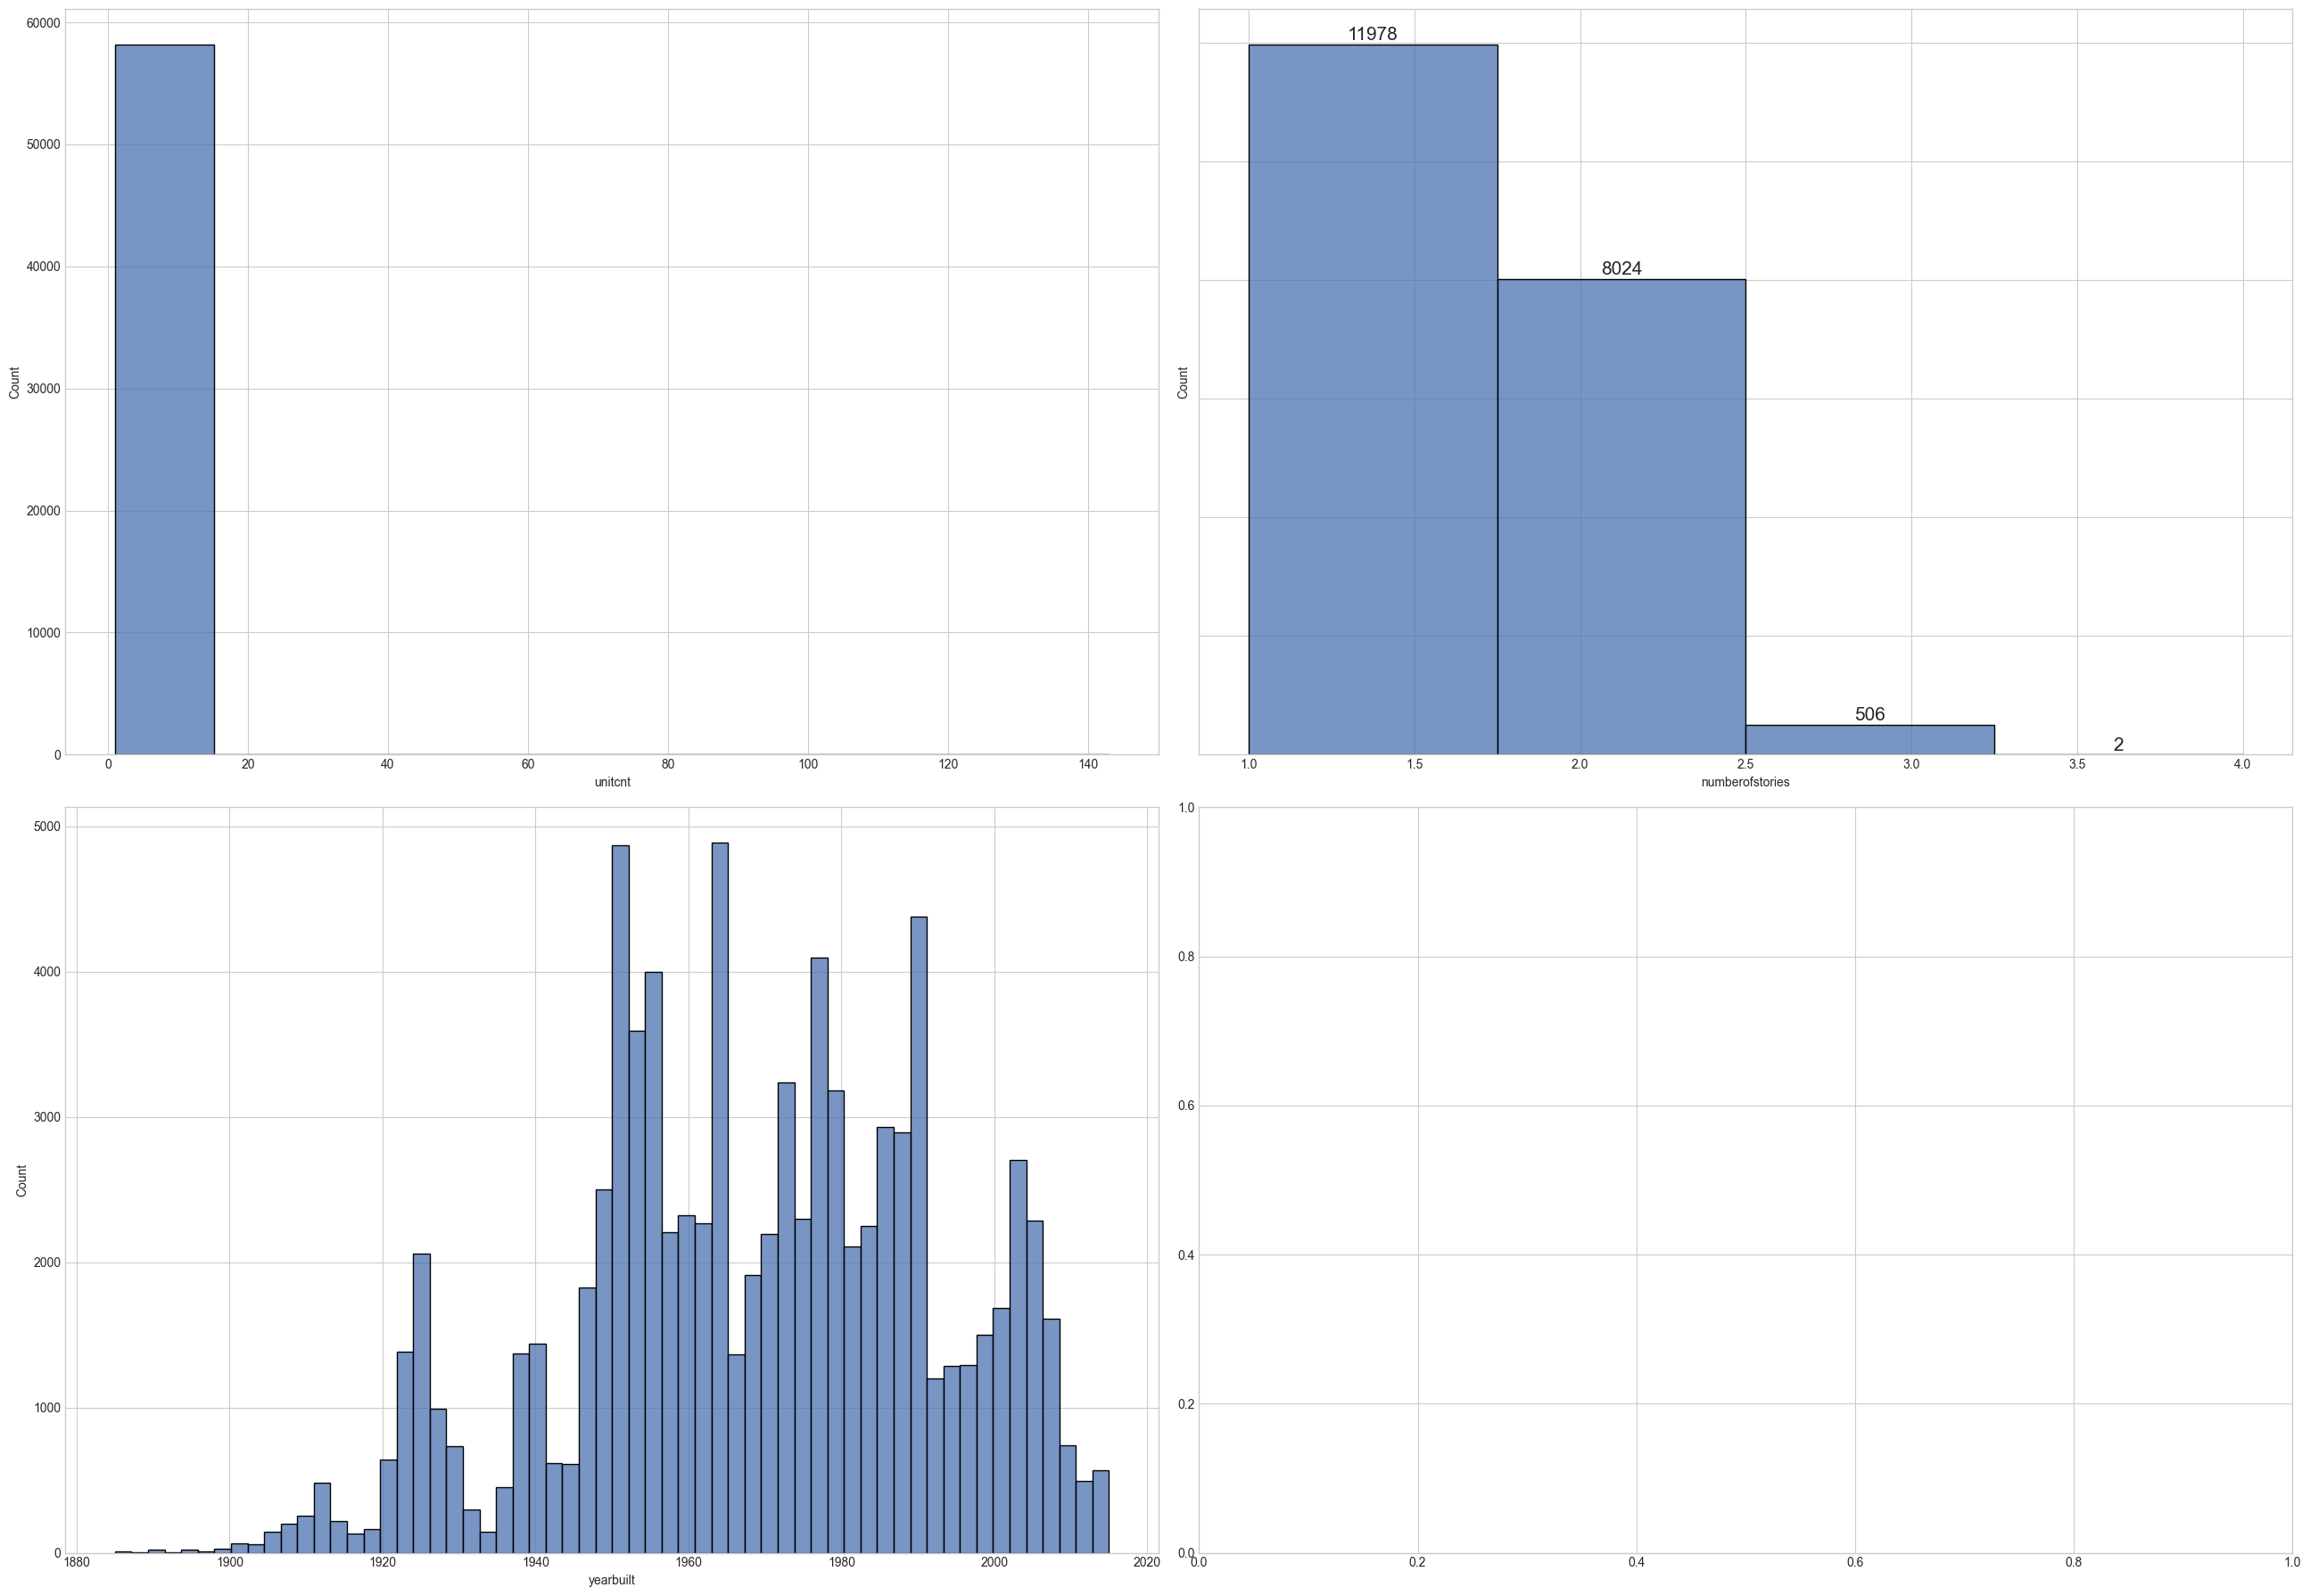

In [27]:
structural_features = find_shared_cols(features_manager.structural, train.columns)
cur_train = train[structural_features]
do_basic_visuals(cur_train, num_args={'dtype_to_convert': np.int16}, plot_kws={'bins':60})

**Conclusions**:
1. 'numberofstories' is categorical and a bit imbalanced.
2. 'unitcnt'
3. 'yearbuild' is good. It's multinomially distributed and have reasonable counts.

##### Taxes

In [ ]:
tax_features = find_shared_cols(features_manager.tax, train.columns)
cur_train = train[tax_features].copy()

cur_train['taxdelinquencyflag'] = cur_train['taxdelinquencyflag'].apply(is_bool_false).astype('int')

# Trimming extremely high values:
columns_to_cap = ['taxvaluedollarcnt', 'structuretaxvaluedollarcnt', 
                  'landtaxvaluedollarcnt', 'taxamount']
cur_train[columns_to_cap] = cur_train[columns_to_cap].clip(upper=
                                        cur_train[columns_to_cap].quantile(0.99), axis=1)

do_basic_visuals(cur_train, num_args={'dtype_to_convert': np.int16}, plot_kws={'bins':40})

There are 7 features. 


'Description of the features from zillow:'

,feature,description
51,taxvaluedollarcnt,The total tax assessed value of the parcel
52,structuretaxvaluedollarcnt,The assessed value of the built structure on the parcel
53,landtaxvaluedollarcnt,The assessed value of the land area of the parcel
54,taxamount,The total property tax assessed for that assessment year
55,assessmentyear,The year of the property tax assessment
56,taxdelinquencyflag,Property taxes for this parcel are past due as of 2015
57,taxdelinquencyyear,Year for which the unpaid propert taxes were due


Unique dtypes: [dtype('int64') dtype('float32') dtype('int16') Int16Dtype()]

Inspection per feature:


,taxdelinquencyflag,landtaxvaluedollarcnt,assessmentyear,taxdelinquencyyear,taxvaluedollarcnt,structuretaxvaluedollarcnt,taxamount
count,90026.0,90025.0,90026.0,1767.0,90025.0,89650.0,90020.0
mean,0.019628,266465.46875,2015.0,13.400679,441510.34375,174222.9375,5782.251953
std,0.138718,280081.65625,0.0,2.724861,399120.46875,154306.6875,4909.502441
min,0.0,22.0,2015.0,6.0,22.0,100.0,49.080002
25%,0.0,82340.0,2015.0,13.0,199073.0,81300.0,2874.419922
50%,0.0,193000.0,2015.0,14.0,343000.0,132096.5,4543.280273
75%,0.0,345373.0,2015.0,15.0,540589.0,210568.0,6899.449707
max,1.0,1686971.75,2015.0,99.0,2477884.75,965968.8125,30837.705078
skewness,6.926046,2.554289,0.0,17.145229,2.591364,2.636338,2.62281
kurtosis,45.971141,8.520917,0.0,551.207931,8.762089,8.93796,8.872766


Histplot visuals:


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001EAAE88BA60> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001EAAF0EE3E0> (for post_execute):


KeyboardInterrupt: 

In [29]:
cur_train['taxdelinquencyyear'].value_counts()

taxdelinquencyyear
14    624
15    512
13    208
12    152
10     89
11     83
9      63
8      24
7       8
6       3
99      1
Name: count, dtype: Int64

**Conclusions**:
1. Imbalanced features: taxdelinquencyyear, taxdelinquencyflag. Some groups of tax del year has too small amount of values.
2. There are not many missing values in all these columns except taxdelinquencyyear which has lots of them. 
3. Dtypes can be capped.
4. Some features have extremely large values.
5. Some features follow heavily rightly skewed normal distributions. One - exponential. 
6. Assessmentyear is heavily imbalanced (especially in properties dataset).

##### Zoning

There are 2 features. 


'Description of the features from zillow:'

,feature,description
35,propertycountylandusecode,County land use code i.e. it's zoning at the county level
37,propertyzoningdesc,Description of the allowed land uses (zoning) for that property


Unique dtypes: [CategoricalDtype(categories=['1NR1*', '1NR3*', 'AH RM-CD*', 'AH RM-CD-F', 'AH RS(3)10',
                   'AH RS-(3)-', 'AHA11*', 'AHA110000*', 'AHA21*', 'AHR110000*',
                   ...
                   'WVRPD112U*', 'WVRPD12U*', 'WVRPD12U-R', 'WVRPD17U*',
                   'WVRPD18U*', 'WVRPD40000', 'WVRPD4OOOO', 'WVRPD56*', 'WVRR',
                   'WVRR1-RPD1'],
 , ordered=False, categories_dtype=object)
 CategoricalDtype(categories=['0', '010', '0100', '0101', '0102', '0103', '0104', '0108',
                   '0109', '010C', '010D', '010E', '010F', '010G', '010H',
                   '010M', '010V', '0110', '0111', '0114', '012C', '012D',
                   '012E', '0130', '0131', '01DC', '01DD', '01HC', '0200',
                   '0201', '020G', '020M', '0210', '0300', '0301', '0303',
                   '030G', '0400', '0401', '040A', '040V', '0700', '070D', '1',
                   '100V', '1011', '1012', '1014', '105', '1110', '1111',
                  

,propertyzoningdesc,propertycountylandusecode
count,58152,90025
unique,1994,77
top,LAR1,0100
freq,7654,30758


Histplot visuals:


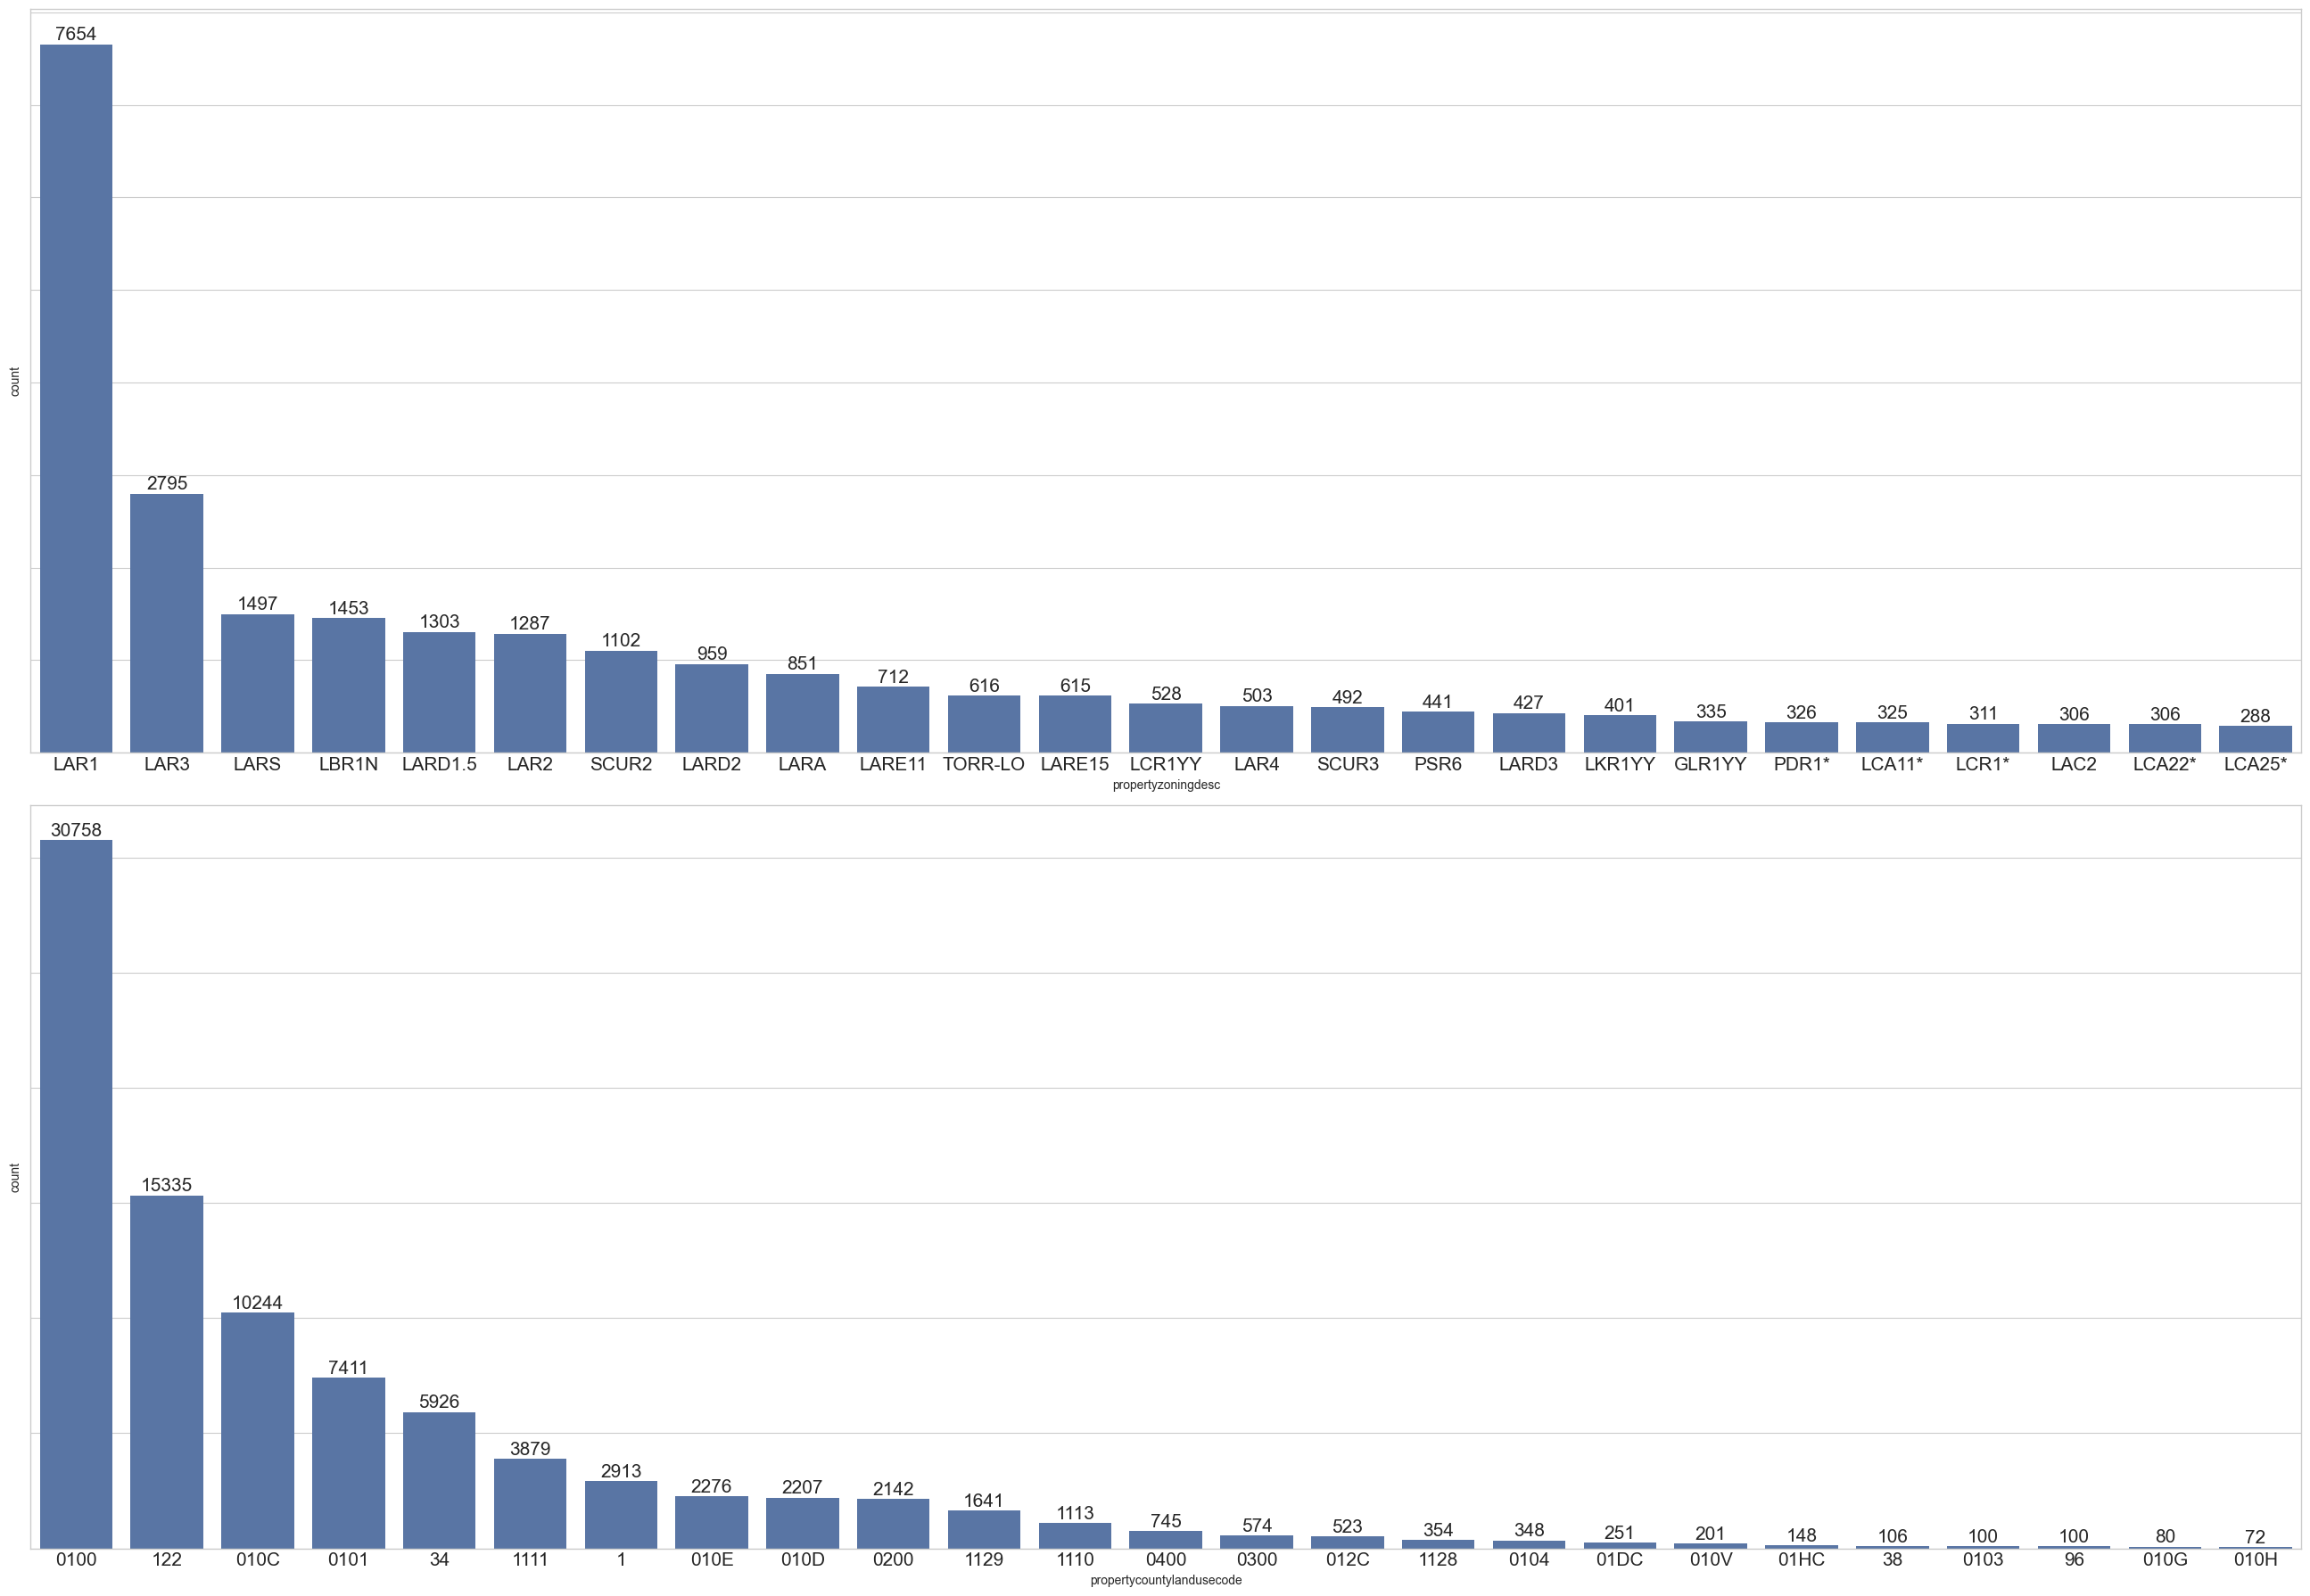

In [30]:
zoning_features = find_shared_cols(features_manager.zoning_landuse, train.columns)
cur_train = train[zoning_features].copy()

for c in zoning_features:
    cur_train[c] = cur_train[c].astype('category')

do_basic_visuals(cur_train, plot_kws={'max_bars': 25, 'to_annotate_counts': True, 'ncols': 1})

**Conclusions**:
1. Well balanced categorical columns with pretty much number of values totally. It's clear that 'propertycountylandusecode' decreases quite fast while 'propertyzoningdesc' changes slowly. 